In [1]:
import wget
#download an example pdb file
url = 'https://files.rcsb.org/download/1EEI.pdb'
#filename = wget.download(url)

In [2]:
filename = './1eei (1).pdb'

In [3]:
import torch_geometric

In [4]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as L

# PyTorch
import torch
import scipy.sparse
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.data import HeteroData

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
aaproperties = pd.read_csv('./aaindex1.csv', header=0)
print(aaproperties.columns)
for i,w in  enumerate(list(aaproperties.description )):
    print(i,w)

colmap = {aaproperties.columns[i]:i for i in range(len(aaproperties.columns))}
aaproperties.drop( [ 'description' , 'reference'  ], axis=1, inplace=True)

print(aaproperties.columns)
print(aaproperties.head())
print(len(aaproperties))

start_onehot = len(aaproperties)+2


Index(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
       'P', 'S', 'T', 'W', 'Y', 'V', 'description', 'reference'],
      dtype='object')
0 alpha-CH chemical shifts (Andersen et al., 1992)
1 Hydrophobicity index (Argos et al., 1982)
2 Signal sequence helical potential (Argos et al., 1982)
3 Membrane-buried preference parameters (Argos et al., 1982)
4 Conformational parameter of inner helix (Beghin-Dirkx, 1975)
5 Conformational parameter of beta-structure (Beghin-Dirkx, 1975)
6 Conformational parameter of beta-turn (Beghin-Dirkx, 1975)
7 Average flexibility indices (Bhaskaran-Ponnuswamy, 1988)
8 Residue volume (Bigelow, 1967)
9 Information value for accessibility; average fraction 35% (Biou et al., 1988)
10 Information value for accessibility; average fraction 23% (Biou et al., 1988)
11 Retention coefficient in TFA (Browne et al., 1982)
12 Retention coefficient in HFBA (Browne et al., 1982)
13 Transfer free energy to surface (Bull-Breese, 1974)
14 Apparent par

In [6]:

#one hot encoding
#get dummies of the index
onehot = pd.get_dummies(aaproperties.columns.unique())
#turn true into 1 and false into 0
onehot = onehot.astype(int)
aaproperties = pd.concat([aaproperties, onehot ] , axis = 0 )
print(aaproperties.head())
print(len(aaproperties))

      A     R     N     D     C     Q     E     G     H     I     L     K  \
0  4.35  4.38  4.75  4.76  4.65  4.37  4.29  3.97  4.63  3.95  4.17  4.36   
1  0.61  0.60  0.06  0.46  1.07  0.00  0.47  0.07  0.61  2.22  1.53  1.15   
2  1.18  0.20  0.23  0.05  1.89  0.72  0.11  0.49  0.31  1.45  3.23  0.06   
3  1.56  0.45  0.27  0.14  1.23  0.51  0.23  0.62  0.29  1.67  2.93  0.15   
4  1.00  0.52  0.35  0.44  0.06  0.44  0.73  0.35  0.60  0.73  1.00  0.60   

      M     F     P     S     T     W     Y     V  
0  4.52  4.66  4.44  4.50  4.35  4.70  4.60  3.95  
1  1.18  2.02  1.95  0.05  0.05  2.65  1.88  1.32  
2  2.67  1.96  0.76  0.97  0.84  0.77  0.39  1.08  
3  2.96  2.03  0.76  0.81  0.91  1.08  0.68  1.14  
4  1.00  0.60  0.06  0.35  0.44  0.73  0.44  0.82  
586


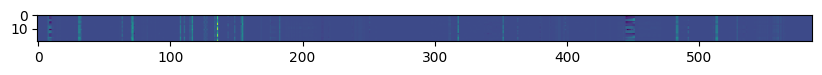

In [7]:

aaproperties = aaproperties.T
aaproperties[aaproperties.isna() == True] = 0
plt.figure( figsize=(10,10) )
plt.imshow(aaproperties)

In [8]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pydssp
from Bio.PDB import PDBParser   
import numpy as np
filename = './1eei.pdb'

def read_pdb(filename):
    #silence all warnings
    warnings.filterwarnings('ignore')

    with warnings.catch_warnings():        
        parser = PDB.PDBParser()
        structure = parser.get_structure(filename, filename)
        chains = [ c for c in structure.get_chains()]
        return chains

#return the phi, psi, and omega angles for each residue in a chain
def get_angles(chain):

    phi_psi_angles = []

    chain = [ r for r in chain if PDB.is_aa(r)]
    #sliding window of 3 residues
    polypeptides = [ chain[i:i+3] for i in range(len(chain)) if len(chain[i:i+4]) >= 3]
    #translate to single letter code


    residue = chain[0]
    residue_id = residue.get_full_id()

    phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": 0,
            "Psi_Angle": 0
        })


    for poly_index, poly in enumerate(polypeptides):
        phi = None
        psi = None

        if len(poly) >= 3:
            c_minus_1 = poly[len(poly) - 3]["C"].get_vector()
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()

            # Calculate phi angle
            phi = PDB.calc_dihedral(c_minus_1, n, ca, c)
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 1]["N"].get_vector()

            # Calculate psi angle
            psi = PDB.calc_dihedral(n, ca, c, n_plus_1)
        residue = poly[0]
        residue_id = residue.get_full_id()

        phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": phi,
            "Psi_Angle": psi
        })

    residue = chain[-1]
    residue_id = residue.get_full_id()

    phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": 0,
            "Psi_Angle": 0
        })
    
    #transform phi and psi angles into a dataframe
    phi_psi_angles = pd.DataFrame(phi_psi_angles)
    #transform the residue names into single letter code
    return phi_psi_angles    

def get_contact_points(chain, distance=25):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            if i< j:
                if 'CA' in r1 and 'CA' in r2:
                    if r1['CA'] - r2['CA'] < distance:
                        contact_mat[i,j] =  r1['CA'] - r2['CA']
    contact_mat = contact_mat + contact_mat.T
    return contact_mat


def get_closest(chain):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            contact_mat[i,j] =  r1['CB'] - r2['CB']
    #go through each row and select min
    for r in contact_mat.shape[0]:
        contact_mat[r, :][ contact_mat[r, :] != np.amin(contact_mat)] =  0
    return contact_mat


def get_backbone(chain):
    backbone_mat = np.zeros((len(chain), len(chain)))
    backbone_rev_mat = np.zeros((len(chain), len(chain)))

    np.fill_diagonal(backbone_mat[1:], 1)
    np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
    
    return backbone_mat, backbone_rev_mat

def ret_hbonds(chain , verbose = False):
    #loop through all atoms in a structure
    struct = PDBParser().get_structure('1eei', filename)

    #N,CA,C,O
    typeindex = {'N':0, 'CA':1 , 'C':2, 'O':3}
    #get the number of atoms in the chain
    #create a numpy array of zeros with the shape of (1, length, atoms, xyz)
    output = np.zeros((1, len(chain), len(typeindex), 3 ))
    for c, res in enumerate(chain):
        atoms = res.get_atoms()
        for at,atom in enumerate(atoms):
            if atom.get_name() in typeindex:
                output[ 0, c ,  typeindex[atom.get_name()] , : ]  = atom.get_coord()
    output = torch.tensor(output)
    if verbose:
        print(output.shape)
    mat =  pydssp.get_hbond_map(output[0])
    return mat

#add the amino acid properties to the angles dataframe
#one hot encode the amino acid properties
def add_aaproperties(angles, aaproperties = aaproperties , verbose = False):
    if verbose == True:
        print(aaproperties , angles )
    nodeprops = angles.merge(aaproperties, left_on='single_letter_code', right_index=True, how='left')
    nodeprops = nodeprops.dropna()

    #generate 1 hot encoding for each amino acid
    #one_hot = pd.get_dummies(nodeprops['single_letter_code']).astype(int)
    #nodeprops = nodeprops.join(one_hot)
    #nodeprops = nodeprops.drop(columns=['single_letter_code'])
    return nodeprops

@> 4630 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Hessian was built in 0.18s.
@> 20 modes were calculated in 0.13s.


(1545, 1545)


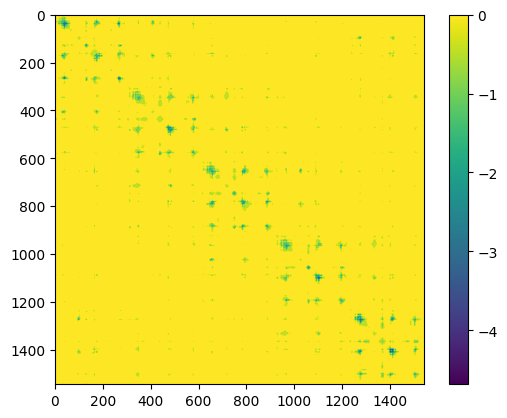

0.005025495886680457
11936


In [9]:
from prody import *
from pylab import *
import warnings
def anm_analysis(filename):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prot = parsePDB( filename  , )
        calphas2 = prot.select('calpha')
        anm = ANM('ANM analysis')
        anm.buildHessian(calphas2)
        anm.calcModes()
        cov = anm.getCovariance()
        cov[ cov < 0] = -cov[ cov < 0]
        logcov = np.log(cov)
        #get the top .5% of the covariance matrix
        top = np.percentile(logcov, 99.5)
        logcov[ logcov < top] = 0
        
        
        return logcov

cov = anm_analysis(filename)
print(cov.shape)

plt.imshow(cov)
plt.colorbar()
plt.show()

#print the number of 0 entries
print( np.sum(cov != 0) /np.sum(cov == 0))
print( np.sum(cov != 0) )

In [10]:
#create features from a monomer pdb file
from scipy import sparse
from copy import deepcopy
def create_features(monomerpdb, aaproperties, distance = 8, verbose = False):
    if type(monomerpdb) == str:    
        chain = read_pdb(monomerpdb)[0]
    else:
        chain = monomerpdb
    chain = [ r for r in chain if PDB.is_aa(r)]
    angles = get_angles(chain)
    if len(angles) ==0:
        return None
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.dropna()
    angles = angles.reset_index(drop=True)
    angles = angles.set_index(['Chain', 'Residue_Number'])
    angles = angles.sort_index()
    angles = angles.reset_index()
    angles = angles.drop(['Chain', 'Residue_Number' , 'Residue_Name'], axis=1)
    vals = deepcopy(angles)
    vals = vals.dropna()
    vals = vals.drop( ['single_letter_code'] , axis = 1 )
    vals = vals.values
    vals = vals.astype('float32')
    if verbose:
        print('vals',vals.shape)   
        plt.imshow(vals)
        plt.colorbar()
        plt.show()

    contact_points = get_contact_points(chain, distance)
    if verbose:
        print('contacts' , contact_points.shape)
        plt.imshow(contact_points)
        plt.colorbar()
        plt.show()
    hbond_mat = np.array(ret_hbonds(chain, verbose))
    if verbose:
        print('hbond' , hbond_mat.shape)
        plt.imshow(hbond_mat)
        plt.colorbar()
        plt.show()
    #return the angles, amino acid properties, contact points, and hydrogen bonds
    #backbone is just the amino acid chain
    backbone , backbone_rev = get_backbone(chain)
    #springmat = anm_analysis(monomerpdb)
    """if verbose:
        print('spring' , springmat.shape)
        plt.imshow(springmat)
        plt.colorbar()
        plt.show()"""
    #change the contac matrices to sparse matrices
    contact_points = sparse.csr_matrix(contact_points)
    #springmat = sparse.csr_matrix(springmat)
    backbone = sparse.csr_matrix(backbone)
    backbone_rev = sparse.csr_matrix(backbone)

    hbond_mat = sparse.csr_matrix(hbond_mat)

    return angles, contact_points, 0 , hbond_mat, backbone , backbone_rev


vals (103, 588)


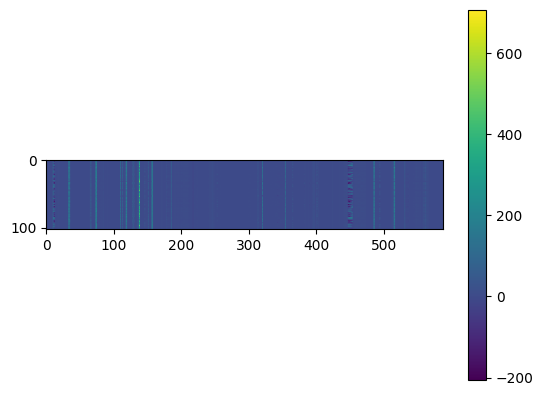

contacts (103, 103)


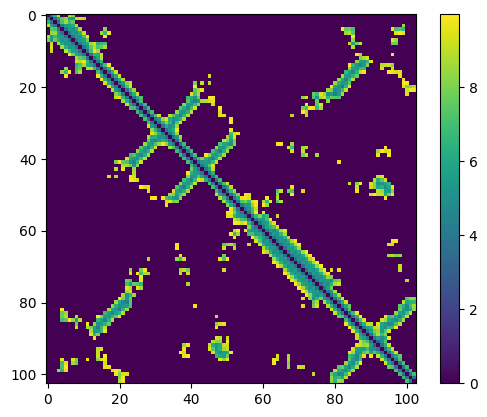

torch.Size([1, 103, 4, 3])
hbond (103, 103)


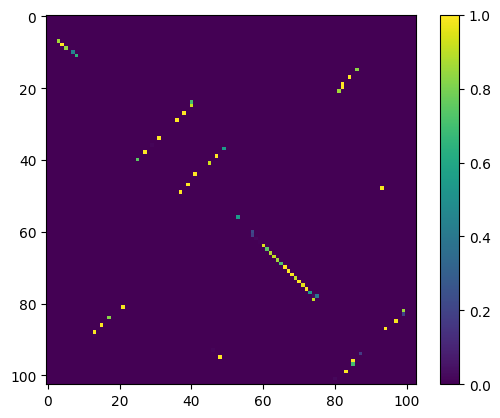

In [11]:
angles, contact_points, blank , hbond_mat, backbone , backbone_rev = create_features(filename, aaproperties, distance = 10, verbose = True)


In [12]:
print(angles.shape)
print( 'one hot aa' , angles.iloc[:,-20:] ) 

(103, 589)
one hot aa        0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
98   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
100  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
101  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
102  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      14   15   16   17   18   19  
0    0.0  0.0  1.

    single_letter_code  Phi_Angle  Psi_Angle     0     1     2     3     4  \
0                    T   0.000000   0.000000  4.35  0.05  0.84  0.91  0.44   
1                    T  -1.047017   2.663062  4.35  0.05  0.84  0.91  0.44   
2                    P  -1.903192  -0.014165  4.44  1.95  0.76  0.76  0.06   
3                    Q  -2.789905   2.943459  4.37  0.00  0.72  0.51  0.44   
4                    N  -1.061407  -0.663699  4.75  0.06  0.23  0.27  0.35   
..                 ...        ...        ...   ...   ...   ...   ...   ...   
98                   A  -2.461680   2.534450  4.35  0.61  1.18  1.56  1.00   
99                   I  -2.263589   2.385299  3.95  2.22  1.45  1.67  0.73   
100                  S  -2.224691   2.443919  4.50  0.05  0.97  0.81  0.35   
101                  M  -2.760119   2.508907  4.52  1.18  2.67  2.96  1.00   
102                  N   0.000000   0.000000  4.75  0.06  0.23  0.27  0.35   

        5     6  ...   11   12   13   14   15   16   17   18   

{0: Text(-0.6269203158297971, -0.9456965267566672, 'T'),
 1: Text(-0.45006726868045394, -0.7950572522020186, 'T'),
 2: Text(-0.6129319135669153, -0.7857707600898047, 'P'),
 3: Text(-0.5947385762777562, -0.6670304679537022, 'Q'),
 4: Text(-0.41165137778943395, -0.42455008143207873, 'N'),
 5: Text(-0.40823987025727654, -0.4829208486090211, 'I'),
 6: Text(-0.41224843882268675, -0.7072597381952138, 'T'),
 7: Text(-0.3567320754230693, -0.6150667746370265, 'D'),
 8: Text(-0.24354631695540968, -0.5577516299834403, 'L'),
 9: Text(-0.2621331085850866, -0.691325510841493, 'C'),
 10: Text(-0.24530821757834387, -0.8019036933137489, 'A'),
 11: Text(-0.1337261410439042, -0.6247385157043895, 'E'),
 12: Text(-0.04240706367209337, -0.7288473756509476, 'Y'),
 13: Text(-0.01821773315437215, -0.6527577102151888, 'H'),
 14: Text(-0.1001393352965073, -0.4730513121366086, 'N'),
 15: Text(-0.18867782409959338, -0.4824753822582236, 'T'),
 16: Text(-0.2714999752133455, -0.3588018353692878, 'Q'),
 17: Text(-0.39

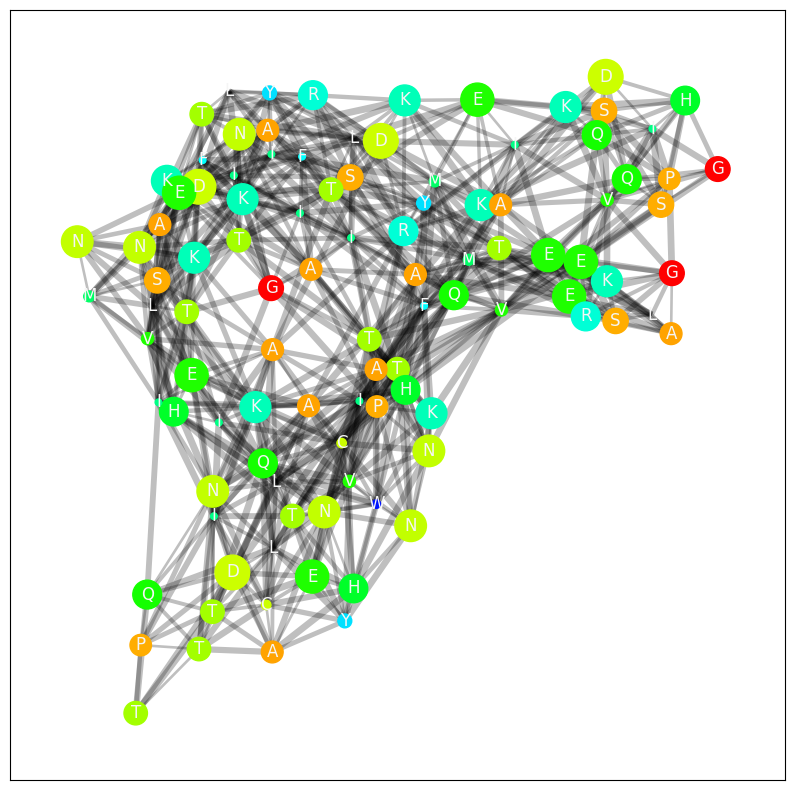

In [13]:
#make a networkx graph from the contact points
import networkx as nx
import matplotlib.pyplot as plt
import colour

def make_graph(contact_points):
    G = nx.Graph()
    G.add_nodes_from(range(contact_points.shape[0]))

    for i in range(contact_points.shape[0]):
        for j in range(contact_points.shape[1]):
            if contact_points[i,j] != 0:
                G.add_edge(i,j, weight = contact_points[i,j] / 2)
    return G

#plot the contact point graph
#make the edges thicker for smaller weights
#make the nodes colors from a column of the angles dataframe


red = colour.Color("red")
blue = colour.Color("blue")
crange = [ c.hex_l for c in list(red.range_to(blue, 101))]


#add a color column to the angles dataframe
angles['color'] = [ int(100*(a-angles[111].min())/angles[111].max()) for a in angles[111]]
angles['color'] = [ crange[a] for a in angles['color']]

print(angles)

G = make_graph(contact_points)
edges = G.edges()
weights = [ G[u][v]['weight'] for u,v in edges]
#change the color of the nodes
colors = [ angles.loc[u]['color'] for u in G.nodes() ]
#change the size of the nodes$
sizes = [ angles.loc[u][110] for u in G.nodes() ]
#keep sizes between 0 and 1000  
sizes = [ 1000* (s - min(sizes))/max(sizes)  for s in sizes]
print( colors)
print( sizes)
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
#draw nodes with colors

#get amino acid sequence from structure

chain = read_pdb(filename)[0]
chain = [ r for r in chain if PDB.is_aa(r)]
seq = [ r.get_resname() for r in chain ]

#label nodes with sequence
labels = { i:aa for i,aa in enumerate(angles.single_letter_code)}

nx.draw_networkx_nodes(G, pos = pos, node_color = colors, node_size = sizes  )

#draw edges with weights
nx.draw_networkx_edges(G, pos = pos, width = weights , alpha = 0.25)
#draw labels
nx.draw_networkx_labels(G, pos = pos, labels = labels , font_color='whitesmoke')

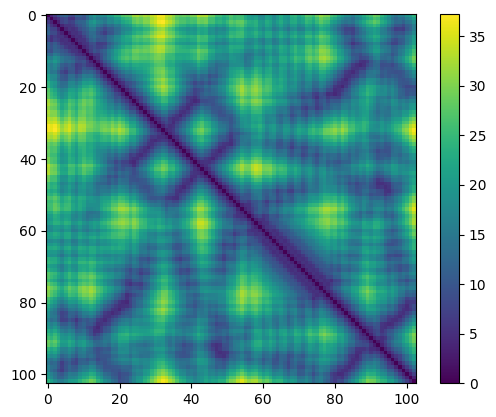

In [14]:
#get the distance matrix of all residues
distances = np.zeros((len(chain), len(chain)))
for i in range(len(chain)):
    for j in range(len(chain)):
        distances[i,j] = chain[i]['CA'] - chain[j]['CA']
plt.imshow(distances)
plt.colorbar()
plt.show()

In [15]:

#write a function to store sparse matrices in an hdf5 file for many pdb files
import h5py
def store_features( pdbfiles, aaproperties, filename, verbose = False):
    #create a hdf5 file
    with h5py.File(filename, 'pdbfiles') as f:
        for pdbfile in pdbfiles:
            if verbose:
                print(pdbfile)
            angles, contact_points, springmat, backbone = create_features(pdbfile, aaproperties, verbose)
            #store the features in the hdf5 file
            f.create_dataset(pdbfile + '_angles', data=angles)
            f.create_dataset(pdbfile + '_contact_points', data=contact_points)
            f.create_dataset(pdbfile + '_springmat', data=springmat)
            f.create_dataset(pdbfile + '_backbone', data=backbone)

In [16]:
import pandas as pd
cols = 'repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId'.split('_')
repdf = pd.read_table( './afdbclusters/2-repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId.tsv')
repdf.columns = cols
print(repdf.head())

        repId  isDark  nMem  repLen   avgLen  repPlddt  avgPlddt  LCAtaxId
0  A0A6M1CKG1       0     3     122  122.667     96.06   88.1467     91347
1  A0A4Q3Q6P1       1     3     117  113.333     71.94   67.8333     80864
2  A0A4V3EFQ4       0     3     153  156.000     68.56   58.8533    131567
3  A0A4V3EKB1       1     3      51   51.000     62.62   62.7700      1883
4  A0A4V3EP89       0     2      96   94.500     70.88   72.1900   2593676


In [17]:
import multiprocessing as mp
import tqdm
import os
import numpy as np
import wget 

def download_pdb(rep ,structdir = './structs/'):
    url = f'https://alphafold.ebi.ac.uk/files/AF-{rep}-F1-model_v4.pdb'
    #check if file exists
    if os.path.exists( structdir + rep + '.pdb'):
        return self.raw_dir + rep + '.pdb'
    filename = wget.download(url, out=structdir + rep + '.pdb')
    return filename

def download(repdf , nreps = 100 , structdir = './structs/'):
    if not os.path.exists(structdir):
        os.makedirs(structdir)
    reps = repdf.repId.unique()
    if nreps:
        #select a random sample of representatives
        reps = np.random.choice(reps, nreps)
    with mp.Pool(20) as p:
        filenames = p.map(download_pdb, tqdm.tqdm(reps))
    return filenames

In [18]:
#download(repdf, nreps = 500 , structdir = './structs/' )


In [19]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

#create the h5 dataset from the pdb files
import glob
import h5py

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [20]:

def sparse2pairs(sparsemat):
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])




def struct2pyg(pdbchain , aaproperties= aaproperties , start_onehot = start_onehot , verbose = False):
    data = HeteroData()
    #transform a structure chain into a pytorch geometric graph
    #get the adjacency matrices
    
    xdata = create_features(pdbchain, aaproperties)
    if data is not None:
        angles, contact_points, springmat , hbond_mat , backbone , backbone_rev = xdata
    else:
        return None
    if len(angles) ==0 :
        return None
    
    angles = angles.drop(['single_letter_code'], axis=1)
    angles.fillna(0, inplace=True)
    
    #just keep the amino acid 1 hot encoding
    AA = angles.iloc[:, -20:]
    #add the amino acid 1 hot to dataset. use for training
    data['AA'].x = torch.tensor(AA.values, dtype=torch.float32)
    
    #use the amino acid properties as the node features
    angles = torch.tensor(angles.values, dtype=torch.float32)
    data['res'].x = angles

    #get the edge features
    data['res','backbone','res'].edge_attr = torch.tensor(backbone.data, dtype=torch.float32)
    data['res','backbonerev','res'].edge_attr = torch.tensor(backbone_rev.data, dtype=torch.float32)
    data['res','contactPoints', 'res'].edge_attr = torch.tensor(contact_points.data, dtype=torch.float32)
    data['res','hbond', 'res'].edge_attr = torch.tensor(hbond_mat.data, dtype=torch.float)
    #data['res','springMat', 'res'].edge_attr = torch.tensor(springmat.data, dtype=torch.float32)

    backbone = sparse2pairs(backbone)
    backbone_rev = sparse2pairs(backbone_rev)
    contact_points = sparse2pairs(contact_points)
    hbond_mat = sparse2pairs(hbond_mat)
    springmat = sparse2pairs(springmat)
    
    #get the adjacency matrices into tensors
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
    
    data['res','contactPoints', 'res'].edge_index = torch.tensor(contact_points,  dtype=torch.long )    
    data['res','hbond', 'res'].edge_index = torch.tensor(hbond_mat,  dtype=torch.long )

    #data['res','springMat', 'res'].edge_index = torch.tensor(springmat,  dtype=torch.long )
    data['res','contactPoints', 'res'].edge_index ,  data['res','contactPoints', 'res'].edge_attr =torch_geometric.utils.to_undirected(  data['res','contactPoints', 'res'].edge_index , data['res','contactPoints', 'res'].edge_attr )


    #add self loops
    data['res','backbone','res'].edge_index = torch_geometric.utils.add_self_loops(data['res','backbone','res'].edge_index)[0]
    data['res','backbonerev','res'].edge_index  = torch_geometric.utils.add_self_loops(data['res','backbonerev','res'].edge_index)[0]
    
    
    #data['res','contactPoints', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','contactPoints', 'res'].edge_index)[0]
    #data['res','hbond_mat', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','hbond_mat', 'res'].edge_index)[0]

    #normalize features

    #data['res'].x = torch_geometric.transforms.NormalizeFeatures(data['res'].x)
    #data['res','contact_points', 'res'].edge_attr = torch_geometric.transforms.normalize_edge_attr(data['res','contact_points', 'res'].edge_attr)
    #data['res','spring_mat', 'res'].edge_index = torch_geometric.transforms.normalize_edge_attr(data['res','spring_mat', 'res'].edge_attr)
    #data['res','hbond_mat', 'res'].edge_attr = torch_geometric.transforms.normalize_edge_attr(data['res','hbond_mat', 'res'].edge_attr)

    return data

#create a function to store the pytorch geometric data in a hdf5 file
def store_pyg(pdbfiles, aaproperties, filename, verbose = True):
    with h5py.File(filename , mode = 'w') as f:
        for pdbfile in tqdm.tqdm(pdbfiles):
            if verbose:
                print(pdbfile)
            hetero_data = struct2pyg(pdbfile, aaproperties)
            if hetero_data:
                f.create_group(pdbfile)

                for node_type in hetero_data.node_types:
                    if hetero_data[node_type].x is not None:
                        node_group = f.create_group(f'{pdbfile}/node/{node_type}')
                        node_group.create_dataset('x', data=hetero_data[node_type].x.numpy())
                        
                # Iterate over edge types and their connections
                for edge_type in hetero_data.edge_types:
                    # edge_type is a tuple: (src_node_type, relation_type, dst_node_type)
                    edge_group = f.create_group(f'{pdbfile}/edge/{edge_type[0]}_{edge_type[1]}_{edge_type[2]}')
                    if hetero_data[edge_type].edge_index is not None:
                        edge_group.create_dataset('edge_index', data=hetero_data[edge_type].edge_index.numpy())
                    
                    # If there are edge features, save them too
                    if hasattr(hetero_data[edge_type], 'edge_attr') and hetero_data[edge_type].edge_attr is not None:
                        edge_group.create_dataset('edge_attr', data=hetero_data[edge_type].edge_attr.numpy())


                    #todo. store some other data. sequence. uniprot info etc.
            else:
                print('err' , pdbfile )
    

In [21]:
metadata = { 'edge_types': [ ('res','backbone','res') , ('res','backbonerev','res') ,  ('res','contactPoints', 'res') , ('res','hbond', 'res') ] }


In [22]:
struct2pyg( filename, aaproperties, verbose=True)

HeteroData(
  AA={ x=[103, 20] },
  res={ x=[103, 588] },
  (res, backbone, res)={
    edge_attr=[102],
    edge_index=[2, 205],
  },
  (res, backbonerev, res)={
    edge_attr=[102],
    edge_index=[2, 205],
  },
  (res, contactPoints, res)={
    edge_attr=[928],
    edge_index=[2, 928],
  },
  (res, hbond, res)={
    edge_attr=[64],
    edge_index=[2, 64],
  }
)

In [23]:
pdbfiles_structalign = glob.glob('./struct_align/*/structs/*.pdb')
#store_pyg(pdbfiles_structalign, aaproperties, filename='structs_structalign.h5', verbose = False)

In [24]:
pdbfiles = glob.glob('./structs/*.pdb')
store_pyg(pdbfiles, aaproperties, filename='structs.h5', verbose = False)

100%|███████████████████████████████████████| 1400/1400 [11:34<00:00,  2.01it/s]


In [25]:
class StructureDataset(Dataset):
    def __init__(self, h5dataset):
        super().__init__()
        #keys should be the structures
        self.structures = h5dataset['structs']
        self.structlist = list(self.structures.keys())
        
    def __len__(self):
        return len(self.structures)

    def __getitem__(self, idx):
        if type(idx) == str:
            f = self.structures[idx]
        elif type(idx) == int:
            f = self.structures[self.structlist[idx]]
        else:
            raise 'use a structure filename or integer'
        data = {}
        hetero_data = HeteroData()
        if 'node' in f.keys():
            for node_type in f['node'].keys():
                node_group = f['node'][node_type]
                # Assuming 'x' exists
                if 'x' in node_group.keys():
                    hetero_data[node_type].x = torch.tensor(node_group['x'][:])
        # Edge data
        if 'edge' in f.keys():
            for edge_name in f['edge'].keys():
                edge_group = f['edge'][edge_name]
                src_type, link_type, dst_type = edge_name.split('_')
                edge_type = (src_type, link_type, dst_type)
                # Assuming 'edge_index' exists
                if 'edge_index' in edge_group.keys():
                    hetero_data[edge_type].edge_index = torch.tensor(edge_group['edge_index'][:])
                
                # If there are edge attributes, load them too
                if 'edge_attr' in edge_group.keys():
                    hetero_data[edge_type].edge_attr = torch.tensor(edge_group['edge_attr'][:])
        #return pytorch geometric heterograph
        return hetero_data
    
    

In [26]:
import time
import h5py

f = h5py.File('./structs.h5' , 'r')
struct_dat = StructureDataset(f)
print( len(struct_dat) )
start = time.time()
print( struct_dat[10] )
print( time.time()-start)

start = time.time()
ndim = struct_dat[20]['res'].x.shape[1]
print( time.time()-start)

1400
HeteroData(
  AA={ x=[156, 20] },
  res={ x=[156, 588] },
  (res, backbone, res)={
    edge_index=[2, 311],
    edge_attr=[155],
  },
  (res, backbonerev, res)={
    edge_index=[2, 311],
    edge_attr=[155],
  },
  (res, contactPoints, res)={
    edge_index=[2, 1350],
    edge_attr=[1350],
  },
  (res, hbond, res)={
    edge_index=[2, 99],
    edge_attr=[99],
  }
)
0.010131597518920898
0.003461122512817383


In [27]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import HeteroData
import networkx as nx
from torch_geometric.data import HeteroData



def remove_self_loops_edge_index(edge_index):
    """
    Removes self-loops from the edge_index of a graph.
    """
    mask = edge_index[0] != edge_index[1]
    return edge_index[:, mask]

def convert_hetero_to_networkx(hetero_data):
    G = nx.MultiDiGraph()  # Use MultiDiGraph to support multiple edge types
    # Add nodes with type as an attribute
    for node_type in hetero_data.node_types:
        for node_id in range(hetero_data[node_type].num_nodes):
            # Node identifier format: (node_type, node_id)
            G.add_node((node_type, node_id), node_type=node_type)
    # Add edges
    for edge_type in hetero_data.edge_types:
        src_type, _, dst_type = edge_type
        edge_indices = hetero_data[edge_type].edge_index
        edge_indices = remove_self_loops_edge_index(edge_indices)
        for i in range(edge_indices.shape[1]):  # Iterate through each edge
            src_id, dst_id = edge_indices[:, i].tolist()
            # Edge identifier format: ((src_type, src_id), (dst_type, dst_id))
            G.add_edge((src_type, src_id), (dst_type, dst_id), edge_type=edge_type)

    return G

def plot_hetero_graph_with_curved_edges(data):
    print(data)
    G = convert_hetero_to_networkx(data)
    print(G)
    pos = nx.spring_layout(G)  # General layout if no positions are provided

    # Calculate offset for curved edges to avoid overlap
    edge_count = {}
    for src, dst, key in G.edges(keys=True):
        edge_count[(src, dst)] = edge_count.get((src, dst), 0) + 1
    # Draw nodes
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=70)
    
    edge_type_colors = {}
    unique_edge_types = data.edge_types
    # Generate a color map from matplotlib, or use a predefined set of colors
    colors = plt.get_cmap('tab20')(range(len(unique_edge_types)))
    for i, edge_type in enumerate(unique_edge_types):
        edge_type_colors[edge_type] = colors[i]

    # Draw edges with curvature
    for (src, dst), count in edge_count.items():
        for i in range(count):
            edge_key = list(G[src][dst])[i]
            style = G[src][dst][edge_key]
            curvature = 0.1 * (i - count // 2)
            nx.draw_networkx_edges(
                G, pos, edgelist=[(src, dst)],
                connectionstyle=f'arc3, rad={curvature}',
                arrowstyle='-|>',
                edge_color = edge_type_colors.get(edge_type, 'black'),  # Default color is black
                width=style.get('weight', 1),
                alpha = .25
            )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    plt.title('Heterogeneous Graph with Curved Edges')
    plt.axis('off')  # Turn off the axis
    plt.show()

In [44]:
from torch_geometric.data import HeteroData
#import sageconv
from torch_geometric.nn import SAGEConv , Linear , FiLMConv
#import module dict and module list
from torch.nn import ModuleDict, ModuleList
from torch_geometric.nn import global_mean_pool
#import negative sampling
from torch_geometric.utils import negative_sampling

class HeteroGAE_Encoder(torch.nn.Module):
    #define a vanilla autoencoder
    def __init__(self, in_channels, hidden_channels, out_channels, metadata={}):
        super(HeteroGAE_Encoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.metadata = metadata
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.in_channels = in_channels
        for i in range(len(hidden_channels)):
            self.convs.append(
                torch.nn.ModuleDict({
                    '_'.join(edge_type): SAGEConv(in_channels if i == 0 else hidden_channels[i-1], hidden_channels[i])
                    for edge_type in metadata['edge_types']
                })
            )
        self.lin = Linear(hidden_channels[-1], out_channels)

    def forward(self, x, edge_index_dict):
        for i, convs in enumerate(self.convs):
            # Apply the graph convolutions and average over all edge types
            x = [ conv(x, edge_index_dict[tuple( edge_type.split('_') ) ]) for edge_type, conv in convs.items() ] 
            #turn into a tensor
            x = torch.stack(x, dim=0).mean(dim=0)
            x = F.relu(x) if i < len(self.hidden_channels) - 1 else x
        return self.lin(x)
    
class HeteroGAE_Decoder(torch.nn.Module):
    def __init__(self, encoder_out_channels , xdim=20 , hidden_channels = { ( 'res','backbone','res'):[20,20,20] , ( 'res','backbonerev','res'):[20,20,20]} , out_channels= 10 , Xdecoder_hidden = 100, metadata={}):
        super(HeteroGAE_Decoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.metadata = metadata
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.in_channels = encoder_out_channels
        
        for i in range(len(self.hidden_channels[( 'res','backbone','res')])):
            self.convs.append(
                torch.nn.ModuleDict({
                    '_'.join(edge_type): SAGEConv(self.in_channels if i == 0 else self.hidden_channels[edge_type][i-1], self.hidden_channels[edge_type][i])
                    for edge_type in [ ( 'res','backbone','res') , ( 'res','backbonerev','res') ]
                })
            )
        
        self.lin = Linear(hidden_channels[( 'res','backbonerev','res')][-1], out_channels)
        #sigmoid to predict the edge probabilities after graph conv
        self.sigmoid = nn.Sigmoid()

        # add stack of dense layers to reconstruct the node features
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(out_channels , Xdecoder_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(Xdecoder_hidden, Xdecoder_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(Xdecoder_hidden , xdim),
        )
    
    def forward(self, z , edge_index , backbones, **kwargs):
        # Transform the latent space if necessary
        edge_probs = {}
        for layer in self.convs:
            for edge_type, conv in layer.items():
                z = conv(z, backbones[tuple(edge_type.split('_'))])
                z = F.relu(z)
        z = self.lin(z)        
        sim_matrix =  (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        edge_probs = self.sigmoid(sim_matrix)
        #turn into connectivity with two columns for edge index
        #edge_probs = torch.stack( torch.where( edge_probs > 0.5 ) , dim=0)
        #reconstruct the node features with decoder
        x_r = self.decoder(z)
        return x_r , edge_probs

    
    def forward_retz(self, z , edge_index , backbone=None, **kwargs):
        # Transform the latent space if necessary
        edge_probs = {}
        for layer in self.convs:
            for edge_type, conv in layer.items():
                z = conv(z, backbones[tuple(edge_type.split('_'))])
                z = F.relu(z)
        z = self.lin(z)
        sim_matrix =  (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        edge_probs = self.sigmoid(sim_matrix)
        #turn into connectivity with two columns for edge index
        #edge_probs = torch.stack( torch.where( edge_probs > 0.5 ) , dim=0)
        #reconstruct the node features with decoder
        x_r = self.decoder(z)

        return x_r , edge_probs , z

EPS = 1e-10
def recon_loss( z: Tensor, pos_edge_index: Tensor , backbone:Tensor = None , backbone_rev=None, decoder = None ) -> Tensor:
    r"""Given latent variables :obj:`z`, computes the binary cross
    entropy loss for positive edges :obj:`pos_edge_index` and negative
    sampled edges.

    Args:
        z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
        pos_edge_index (torch.Tensor): The positive edges to train against.
        neg_edge_index (torch.Tensor, optional): The negative edges to
            train against. If not given, uses negative sampling to
            calculate negative edges. (default: :obj:`None`)
    """
    
    pos =decoder(z, pos_edge_index, { ( 'res','backbone','res'): backbone , ( 'res','backbonerev','res'):backbone_rev } )[1]
    #turn pos edge index into a binary matrix
    pos_loss = -torch.log( pos + EPS).mean()
    neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
    neg = decoder(z ,  neg_edge_index, { ( 'res','backbone','res'): backbone , ( 'res','backbonerev','res'):backbone_rev } )[1]
    neg_loss = -torch.log( ( 1 - neg) + EPS ).mean()
    return pos_loss + neg_loss

#define loss for x reconstruction   
def x_reconstruction_loss(x, recon_x):
    """
    compute the loss over the node feature reconstruction.
    """
    return F.mse_loss(recon_x, x)


#amino acid onehot loss for x reconstruction
def aa_reconstruction_loss(x, recon_x):
    """
    compute the loss over the node feature reconstruction.
    using categorical cross entropy
    """
    
    return F.cross_entropy(recon_x, x)


In [45]:
#try variational auto encoder
"""

class HeteroGAE_Encoder(torch.nn.Module):
    #define a vanilla autoencoder
    def __init__(self, in_channels, hidden_channels, out_channels, metadata={}):
        super(HeteroGAE_Encoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.metadata = metadata
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.gaussian = 


        for i in range(len(hidden_channels)):
            self.convs.append(
                torch.nn.ModuleDict({
                    '_'.join(edge_type): SAGEConv(in_channels if i == 0 else hidden_channels[i-1], hidden_channels[i])
                    for edge_type in metadata['edge_types']
                })
            )
        self.mus = Linear(hidden_channels[-1], out_channels)
        self.logvars = Linear(hidden_channels[-1], out_channels)
    def forward(self, x, edge_index_dict):
        for i, convs in enumerate(self.convs):
            # Apply the graph convolutions and average over all edge types
            x = [ conv(x, edge_index_dict[tuple( edge_type.split('_') ) ]) for edge_type, conv in convs.items() ] 
            #turn into a tensor
            x = torch.stack(x, dim=0).mean(dim=0)
            x = F.relu(x) if i < len(self.hidden_channels) - 1 else x
        
        # Compute mean and log variance
        mu = self.mus(x)
        log_var = self.log_vars(x)
        
        # Optionally, reparameterize if training for variational autoencoder functionality
        x_reparam = self.reparameterize(mu, log_var)
        
        # Here, you could return mu and log_var if needed, or just the reparameterized version
        return mu, log_var, x_reparam

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

EPS = 1e-10
def recon_loss( z: Tensor, pos_edge_index: Tensor , backbone:Tensor = None , decoder = None ) -> Tensor:
    r"""Given latent variables :obj:`z`, computes the binary cross
    entropy loss for positive edges :obj:`pos_edge_index` and negative
    sampled edges.

    Args:
        z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
        pos_edge_index (torch.Tensor): The positive edges to train against.
        neg_edge_index (torch.Tensor, optional): The negative edges to
            train against. If not given, uses negative sampling to
            calculate negative edges. (default: :obj:`None`)
    """
    pos =decoder(z, pos_edge_index, backbone )[1]
    #turn pos edge index into a binary matrix
    pos_loss = -torch.log( pos + EPS).mean()
    neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
    neg = decoder(z ,  neg_edge_index, backbone )[1]
    neg_loss = -torch.log( ( 1 - neg) + EPS ).mean()
    return pos_loss + neg_loss


#define loss for x reconstruction   
def x_reconstruction_loss_vgae(x, recon_x):
    """
    compute the loss over the node feature reconstruction.
    """
    return F.mse_loss(recon_x, x)


#amino acid onehot loss for x reconstruction
def aa_reconstruction_loss_vgae(x, recon_x):
    """
    compute the loss over the node feature reconstruction.
    using categorical cross entropy
    """
    
    return F.cross_entropy(recon_x, x)

#todo: tune beta param dor disentangling
def loss_w_KL( lossfun, mu, logvar, x, recon_x , beta = 1.5):
    """
    add the KL divergence to the loss function
    """
    return lossfun(x, recon_x) + beta * 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
"""

SyntaxError: invalid syntax (3241149763.py, line 53)

In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import VGAE
from torch.optim import Adam
from torch_geometric.data import DataLoader
import pickle
#create a training loop for the GAE model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device( 'cpu')
print(device)
encoder = HeteroGAE_Encoder(in_channels=ndim, hidden_channels=[10]*5, out_channels=10, metadata=metadata)
decoder = HeteroGAE_Decoder(encoder_out_channels = encoder.out_channels, xdim=20, 
                            hidden_channels={ ( 'res','backbone','res'):[ 10 ]* 8 ,  ( 'res','backbonerev','res'):[10]*8 } , out_channels=10, metadata=metadata)

encoder_save = 'encoder_mk2_aa_10'
decoder_save = 'decoder_mk2_aa_20'

#save the blank encoder and decoder
with open(encoder_save + '.pkl' , 'wb') as encodeout:
    encodeout.write( pickle.dumps( encoder))

with open(decoder_save + '.pkl' , 'wb') as encodeout:
    encodeout.write( pickle.dumps( decoder))

#put encoder and decoder on the device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Create a DataLoader for training
train_loader = DataLoader(struct_dat, batch_size=20, shuffle=True)
total_loss_x = 0
total_loss_edge = 0
# Training loop

cuda


In [55]:
print( encoder , decoder )

HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): SAGEConv(588, 10, aggr=mean)
      (res_backbonerev_res): SAGEConv(588, 10, aggr=mean)
      (res_contactPoints_res): SAGEConv(588, 10, aggr=mean)
      (res_hbond_res): SAGEConv(588, 10, aggr=mean)
    )
    (1-4): 4 x ModuleDict(
      (res_backbone_res): SAGEConv(10, 10, aggr=mean)
      (res_backbonerev_res): SAGEConv(10, 10, aggr=mean)
      (res_contactPoints_res): SAGEConv(10, 10, aggr=mean)
      (res_hbond_res): SAGEConv(10, 10, aggr=mean)
    )
  )
  (lin): Linear(10, 10, bias=True)
) HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-7): 8 x ModuleDict(
      (res_backbone_res): SAGEConv(10, 10, aggr=mean)
      (res_backbonerev_res): SAGEConv(10, 10, aggr=mean)
    )
  )
  (lin): Linear(10, 10, bias=True)
  (sigmoid): Sigmoid()
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)

In [56]:
#load model if it exists

"""
if os.path.exists(encoder_save+ '.pth') and os.path.exists(decoder_save+ '.pth'):
    encoder.load_state_dict(torch.load(encoder_save + '.pth'))
    decoder.load_state_dict(torch.load(decoder_save + '.pth' ))
"""


"\nif os.path.exists(encoder_save+ '.pth') and os.path.exists(decoder_save+ '.pth'):\n    encoder.load_state_dict(torch.load(encoder_save + '.pth'))\n    decoder.load_state_dict(torch.load(decoder_save + '.pth' ))\n"

In [57]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
encoder.train()
decoder.train()
for epoch in range(500):
    for data in tqdm.tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z = encoder.forward(data['res'].x, data.edge_index_dict)
        edgeloss = recon_loss(z , data.edge_index_dict[( 'res','contactPoints','res')] , data.edge_index_dict[( 'res','backbone','res')] , data.edge_index_dict[( 'res','backbonerev','res')] , decoder)
        recon_x, edge_probs = decoder(z, data.edge_index_dict[( 'res','contactPoints','res')] , data.edge_index_dict )
        #xloss = x_reconstruction_loss(data['res'].x, recon_x)
        xloss = x_reconstruction_loss(data['AA'].x, recon_x)
        loss = xloss + 2000*edgeloss
        loss.backward()
        optimizer.step()
        total_loss_edge += edgeloss.item()
        total_loss_x += xloss.item()
        del loss
        del xloss
        del edgeloss
    print(f'Epoch {epoch}, Loss: {total_loss_x:.4f}, Edge Loss: {total_loss_edge:.4f}')
    total_loss_x = 0
    total_loss_edge = 0

100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.03it/s]


Epoch 0, Loss: 3.3116, Edge Loss: 97.3128


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.04it/s]


Epoch 1, Loss: 3.2954, Edge Loss: 95.9523


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.20it/s]


Epoch 2, Loss: 3.2918, Edge Loss: 86.9933


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.05it/s]


Epoch 3, Loss: 3.2912, Edge Loss: 84.7389


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.10it/s]


Epoch 4, Loss: 3.2905, Edge Loss: 83.3273


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.90it/s]


Epoch 5, Loss: 3.2900, Edge Loss: 82.9415


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.01it/s]


Epoch 6, Loss: 3.2902, Edge Loss: 82.6904


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.87it/s]


Epoch 7, Loss: 3.2904, Edge Loss: 81.8895


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.18it/s]


Epoch 8, Loss: 3.2905, Edge Loss: 81.3329


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.88it/s]


Epoch 9, Loss: 3.2895, Edge Loss: 80.9534


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.20it/s]


Epoch 10, Loss: 3.2892, Edge Loss: 80.2983


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.00it/s]


Epoch 11, Loss: 3.2892, Edge Loss: 79.2572


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.90it/s]


Epoch 12, Loss: 3.2881, Edge Loss: 78.7461


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.09it/s]


Epoch 13, Loss: 3.2870, Edge Loss: 78.1575


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.94it/s]


Epoch 14, Loss: 3.2867, Edge Loss: 77.8414


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.11it/s]


Epoch 15, Loss: 3.2854, Edge Loss: 76.8836


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.32it/s]


Epoch 16, Loss: 3.2849, Edge Loss: 76.5256


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.09it/s]


Epoch 17, Loss: 3.2847, Edge Loss: 76.8480


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.91it/s]


Epoch 18, Loss: 3.2844, Edge Loss: 76.6060


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.03it/s]


Epoch 19, Loss: 3.2841, Edge Loss: 75.8414


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.14it/s]


Epoch 20, Loss: 3.2838, Edge Loss: 75.9006


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.20it/s]


Epoch 21, Loss: 3.2835, Edge Loss: 75.3260


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.08it/s]


Epoch 22, Loss: 3.2834, Edge Loss: 75.2358


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.01it/s]


Epoch 23, Loss: 3.2829, Edge Loss: 74.9114


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.03it/s]


Epoch 24, Loss: 3.2832, Edge Loss: 74.7383


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.22it/s]


Epoch 25, Loss: 3.2833, Edge Loss: 75.0212


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.15it/s]


Epoch 26, Loss: 3.2833, Edge Loss: 74.7547


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.09it/s]


Epoch 27, Loss: 3.2830, Edge Loss: 74.6975


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.02it/s]


Epoch 28, Loss: 3.2832, Edge Loss: 74.9867


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.12it/s]


Epoch 29, Loss: 3.2826, Edge Loss: 74.2200


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.88it/s]


Epoch 30, Loss: 3.2828, Edge Loss: 74.0002


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.09it/s]


Epoch 31, Loss: 3.2827, Edge Loss: 73.9580


 60%|█████████████████████████▊                 | 42/70 [00:07<00:05,  5.33it/s]


KeyboardInterrupt: 

In [58]:
#add the encoded structures to the struct align hdf5
import time
import h5py

f = h5py.File('./structs_structalign.h5' , 'r')
aln_dat = StructureDataset(f)
aln_loader = DataLoader(aln_dat, batch_size=10, shuffle=True)

#encode each element in the dataset




KeyError: "Unable to synchronously open object (object 'structs' doesn't exist)"

In [59]:
#save model
torch.save(encoder.state_dict(), encoder_save)
torch.save(decoder.state_dict(), decoder_save)



In [63]:
#predict the embeddings for a structure
def predict_structure(structure, encoder, decoder):
    data = struct2pyg(structure, aaproperties)
    data = data.to(device)
    z = encoder.forward(data['res'].x, data.edge_index_dict)
    #create all vs all edge index
    edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T

    recon_x, edge_probs = decoder(z, edge_index , data.edge_index_dict )
    
    return z, recon_x, edge_probs

In [64]:
#predict the embeddings for a few structures
structures = glob.glob('./structs/*.pdb')
zvals_stack = []
edge_probs_stack = []

for structure in structures[0:10]:
    z, recon_x, edge_probs = predict_structure(structure, encoder, decoder)
    z = z.detach().cpu().numpy()
    zvals_stack.append(z)
    edge_probs_stack.append(edge_probs.detach().cpu().numpy())
    print(z.shape)

zvals = np.vstack(zvals_stack)
#edge_probs_stack = np.vstack(edge_probs_stack)
print(zvals.shape)


(281, 10)
(194, 10)
(684, 10)
(271, 10)
(418, 10)
(374, 10)
(723, 10)
(69, 10)
(126, 10)
(153, 10)
(3293, 10)


In [65]:
plot_embeddings(filename, encoder, decoder)


NameError: name 'plot_embeddings' is not defined

./structs/A0A182QEX7.pdb
(78961,)
(281, 281)
[[0.79838187 0.7983936  0.7984025  ... 0.77184457 0.8009673  0.7982562 ]
 [0.7983936  0.7984053  0.7984142  ... 0.77185625 0.8009791  0.7982679 ]
 [0.7984025  0.7984142  0.79842305 ... 0.7718643  0.80098784 0.7982768 ]
 ...
 [0.77184457 0.77185625 0.7718643  ... 0.78265053 0.77846354 0.771759  ]
 [0.8009673  0.8009791  0.80098784 ... 0.77846354 0.8040014  0.80084515]
 [0.7982562  0.7982679  0.7982768  ... 0.771759   0.80084515 0.7981307 ]]


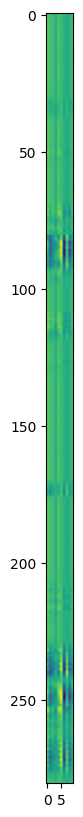

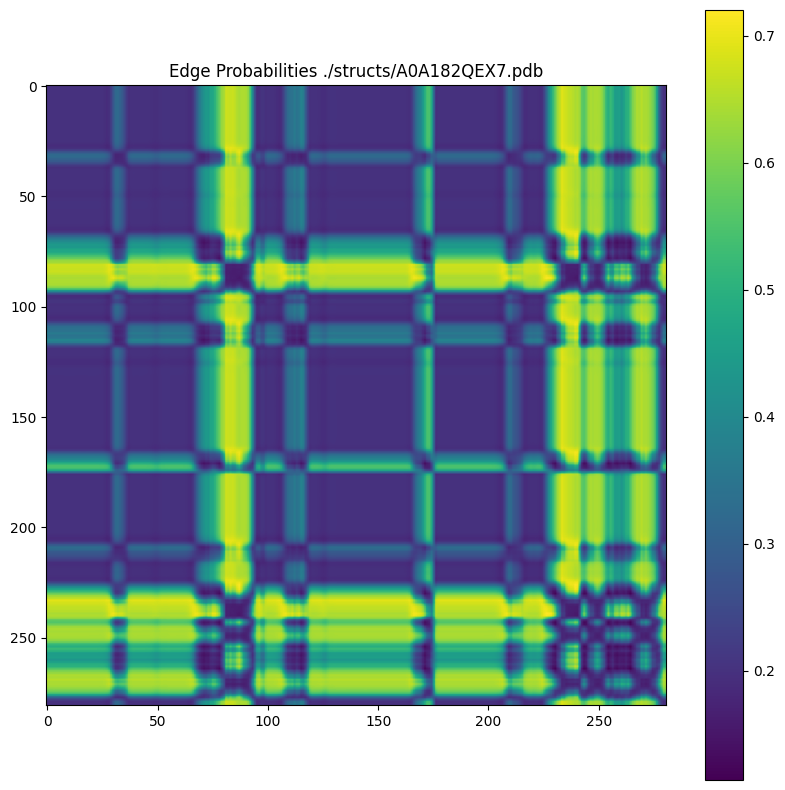

./structs/A0A1B6MIL6.pdb
(37636,)
(194, 194)
[[0.7829967  0.7845444  0.78027856 ... 0.7118627  0.7409039  0.766888  ]
 [0.7845444  0.79818034 0.8024942  ... 0.76545435 0.7866282  0.8056113 ]
 [0.78027856 0.8024942  0.8125625  ... 0.7957711  0.811628   0.82597154]
 ...
 [0.7118627  0.76545435 0.7957711  ... 0.84816194 0.8463404  0.8443475 ]
 [0.7409039  0.7866282  0.811628   ... 0.8463404  0.848791   0.85087776]
 [0.766888   0.8056113  0.82597154 ... 0.8443475  0.85087776 0.85684794]]


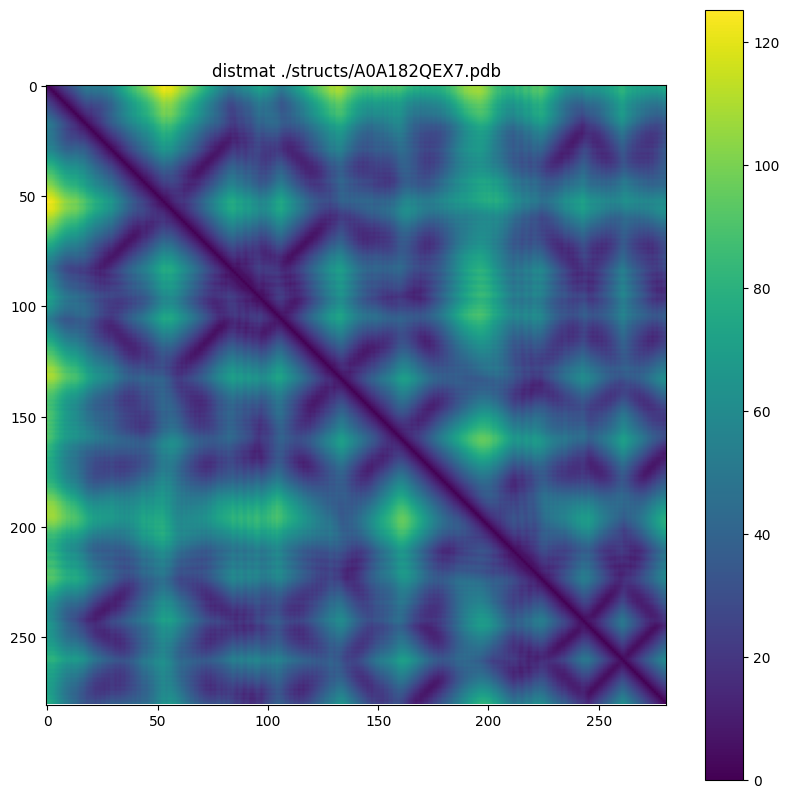

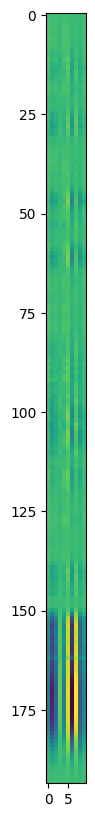

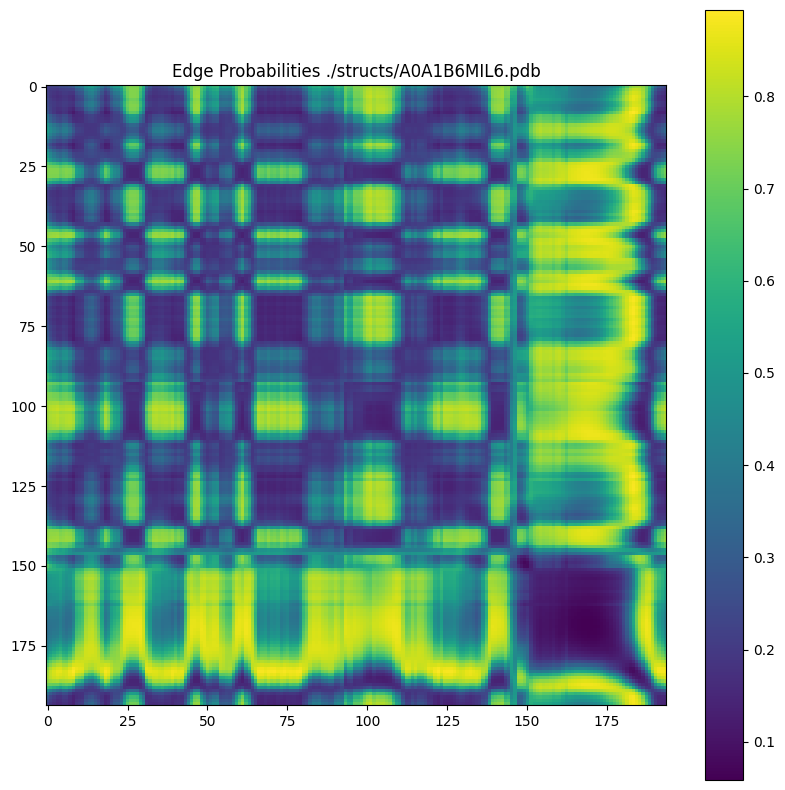

./structs/A0A2X0NIQ0.pdb
(467856,)
(684, 684)
[[0.7983404  0.7984175  0.7985626  ... 0.7983755  0.7983755  0.7983755 ]
 [0.7984175  0.7984948  0.79864    ... 0.79845256 0.79845256 0.79845256]
 [0.7985626  0.79864    0.7987854  ... 0.79859746 0.79859746 0.79859746]
 ...
 [0.7983755  0.79845256 0.79859746 ... 0.7984108  0.7984108  0.7984108 ]
 [0.7983755  0.79845256 0.79859746 ... 0.7984108  0.7984108  0.7984108 ]
 [0.7983755  0.79845256 0.79859746 ... 0.7984108  0.7984108  0.7984108 ]]


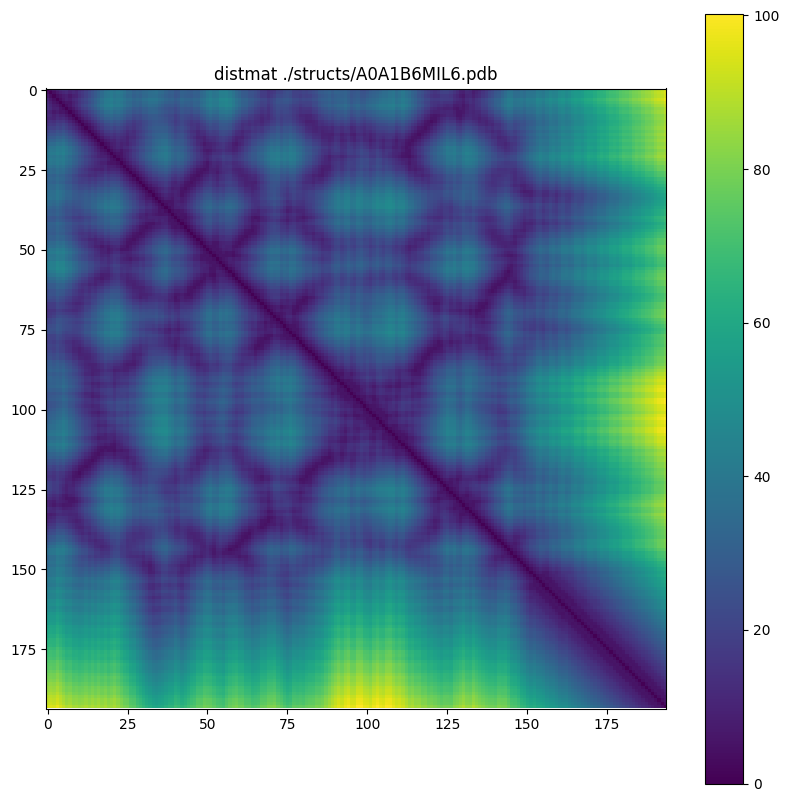

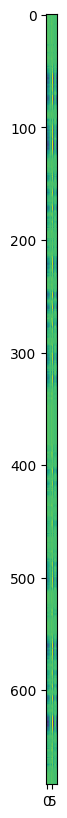

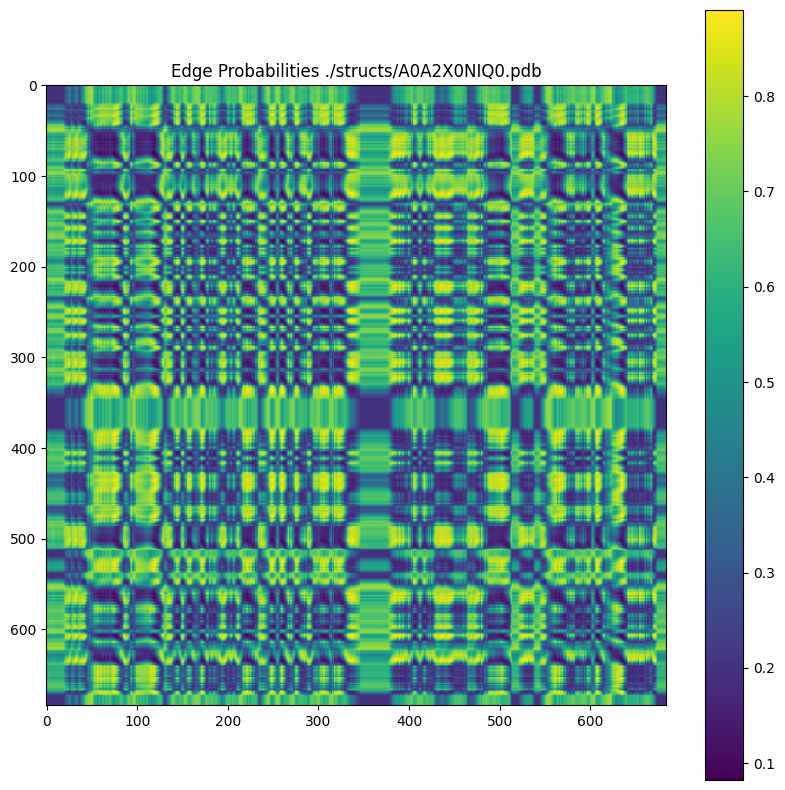

./structs/A0A3C0CY76.pdb
(73441,)
(271, 271)
[[0.88302356 0.88156956 0.8761179  ... 0.2961833  0.30151886 0.30552614]
 [0.88156956 0.88408774 0.8842214  ... 0.3365159  0.34001252 0.3428909 ]
 [0.8761179  0.8842214  0.89262533 ... 0.4086531  0.4104009  0.41244507]
 ...
 [0.2961833  0.3365159  0.4086531  ... 0.8257923  0.8197648  0.8162649 ]
 [0.30151886 0.34001252 0.4104009  ... 0.8197648  0.814481   0.81155026]
 [0.30552614 0.3428909  0.41244507 ... 0.8162649  0.81155026 0.809054  ]]


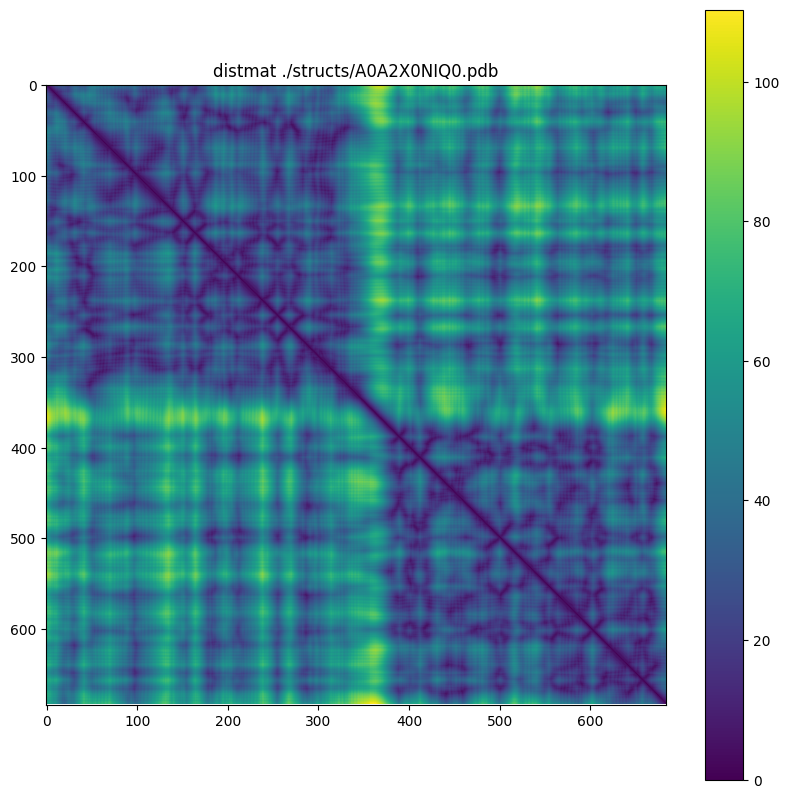

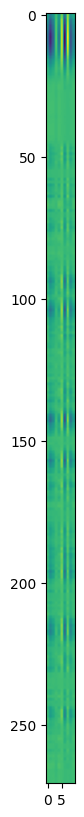

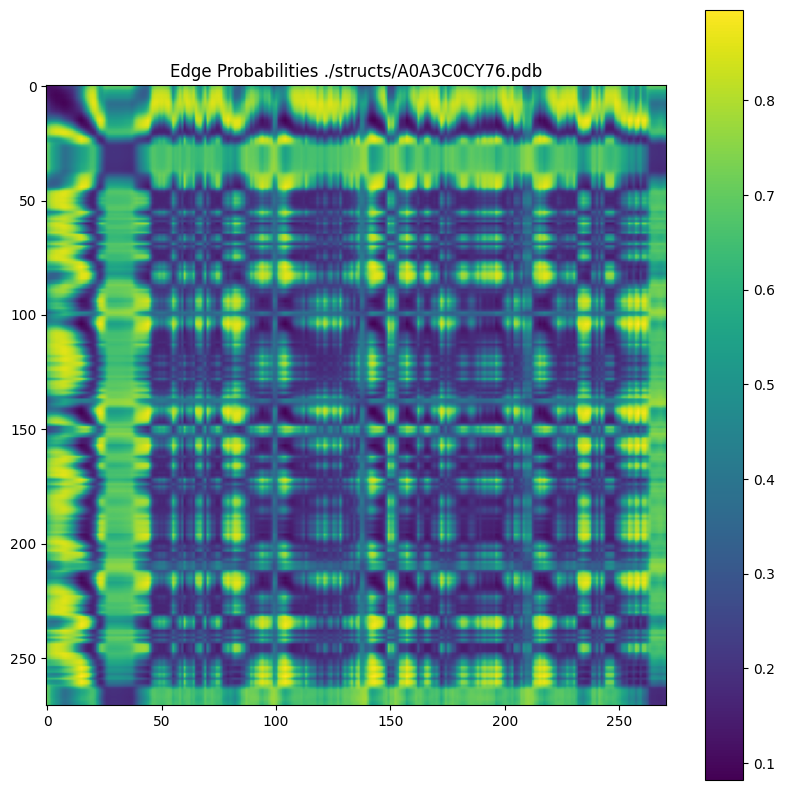

./structs/A0A1Z9J3Y7.pdb
(174724,)
(418, 418)
[[0.8253075  0.83435833 0.8287944  ... 0.4611215  0.46111533 0.46111527]
 [0.83435833 0.8459096  0.837922   ... 0.46799928 0.46799237 0.46799228]
 [0.8287944  0.837922   0.83236057 ... 0.46606308 0.46605667 0.46605667]
 ...
 [0.4611215  0.46799928 0.46606308 ... 0.7984172  0.79841363 0.79841363]
 [0.46111533 0.46799237 0.46605667 ... 0.79841363 0.79841024 0.7984102 ]
 [0.46111527 0.46799228 0.46605667 ... 0.79841363 0.7984102  0.79841   ]]


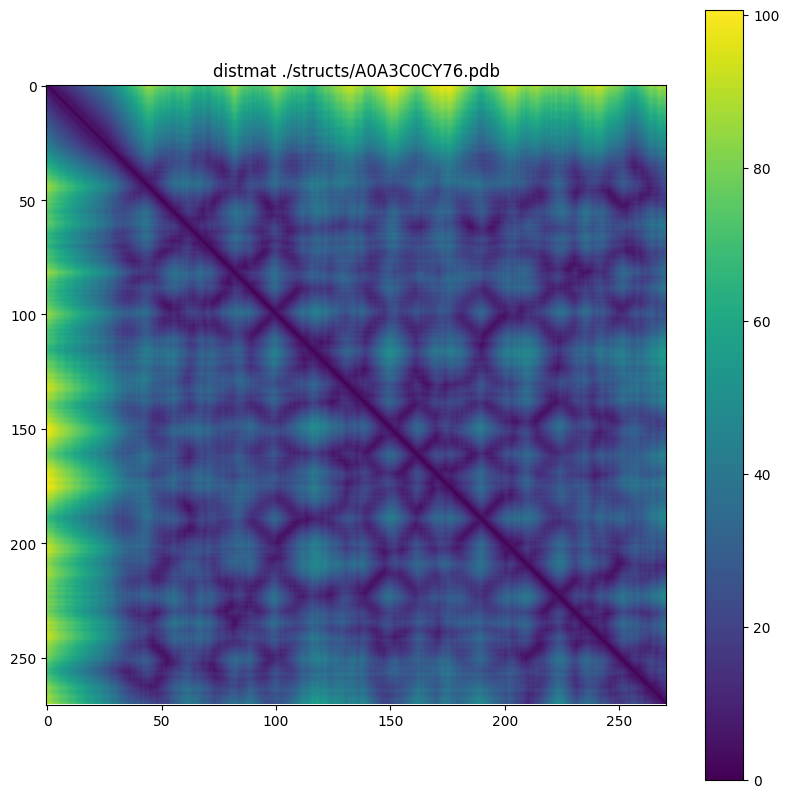

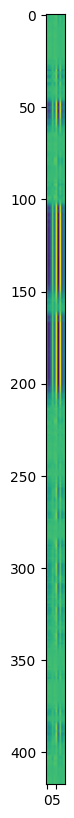

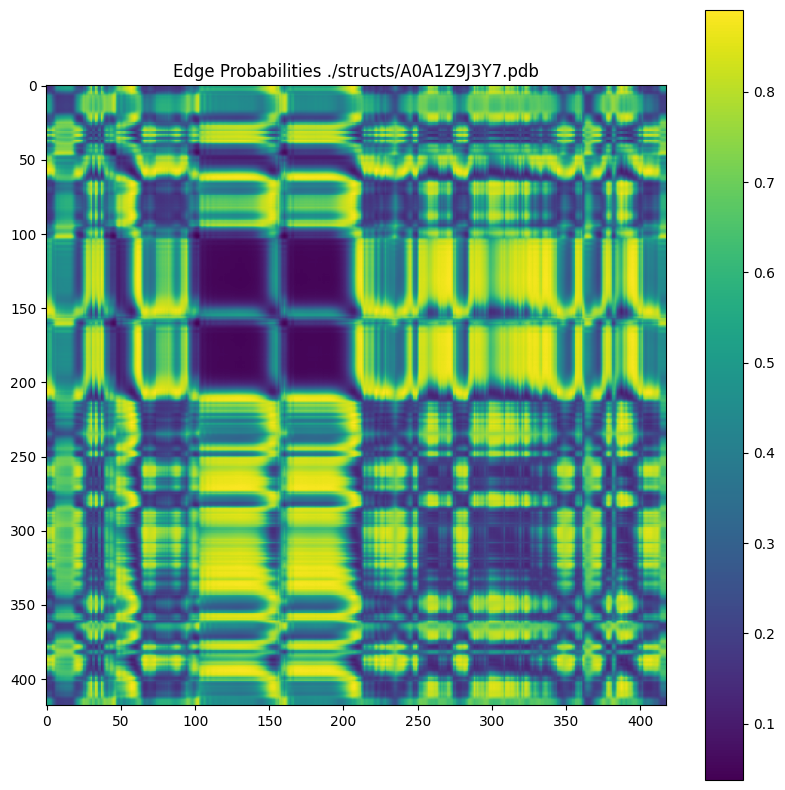

./structs/F4IL37.pdb
(139876,)
(374, 374)
[[0.79841506 0.7984322  0.79844314 ... 0.37794894 0.38259757 0.38338712]
 [0.7984322  0.79844934 0.7984603  ... 0.37793654 0.38258627 0.38337597]
 [0.79844314 0.7984603  0.7984713  ... 0.37793243 0.38258302 0.38337287]
 ...
 [0.37794894 0.37793654 0.37793243 ... 0.81824785 0.819241   0.81942725]
 [0.38259757 0.38258627 0.38258302 ... 0.819241   0.8213141  0.8216864 ]
 [0.38338712 0.38337597 0.38337287 ... 0.81942725 0.8216864  0.82209057]]


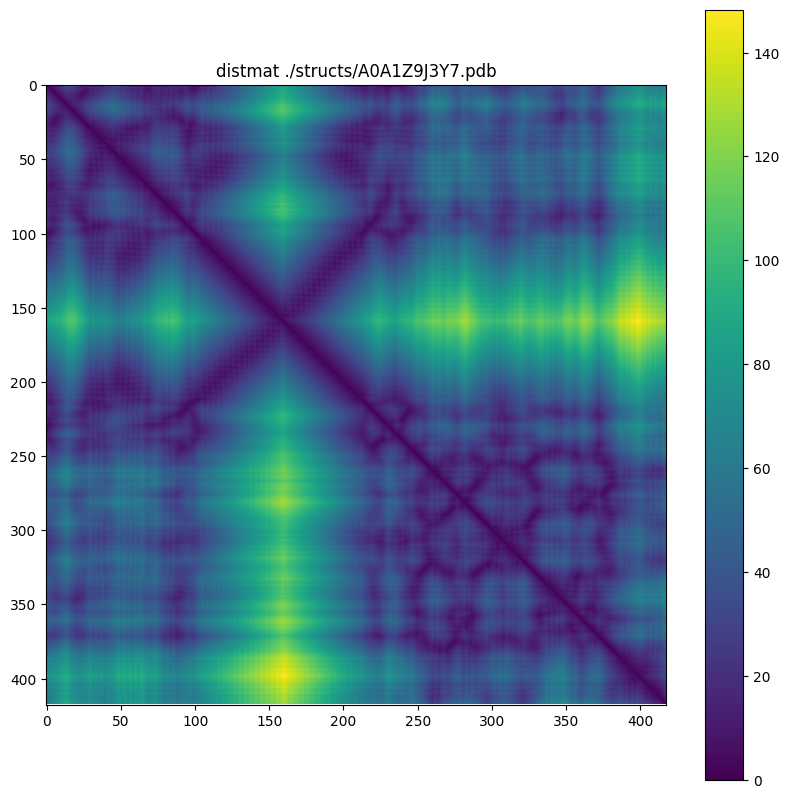

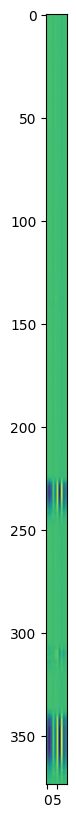

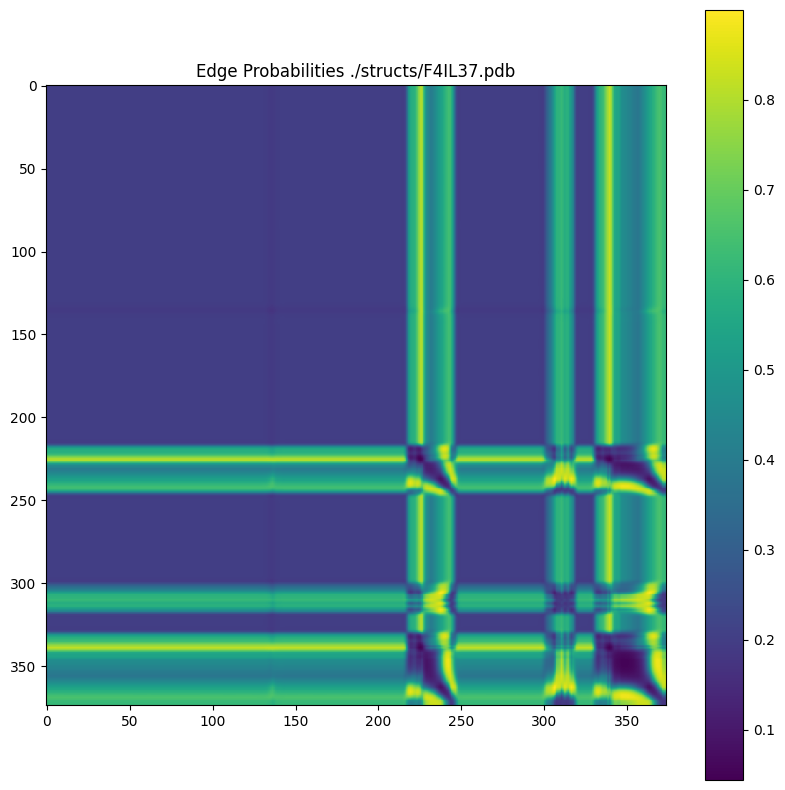

./structs/A0A093ZM93.pdb
(522729,)
(723, 723)
[[0.76104647 0.6999387  0.6226809  ... 0.49779505 0.5531359  0.5994014 ]
 [0.6999387  0.7331819  0.7447778  ... 0.5975389  0.6544342  0.70609504]
 [0.6226809  0.7447778  0.8156847  ... 0.6621029  0.71469206 0.76544416]
 ...
 [0.49779505 0.5975389  0.6621029  ... 0.81759083 0.8167897  0.8189786 ]
 [0.5531359  0.6544342  0.71469206 ... 0.8167897  0.8261059  0.83743507]
 [0.5994014  0.70609504 0.76544416 ... 0.8189786  0.83743507 0.8564033 ]]


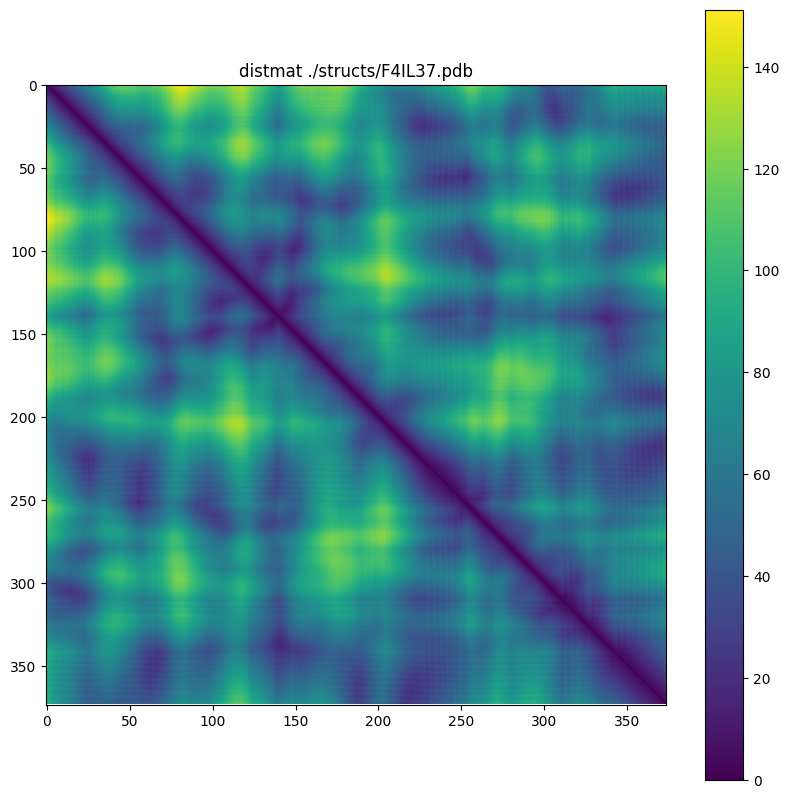

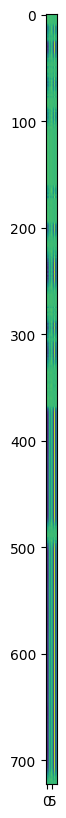

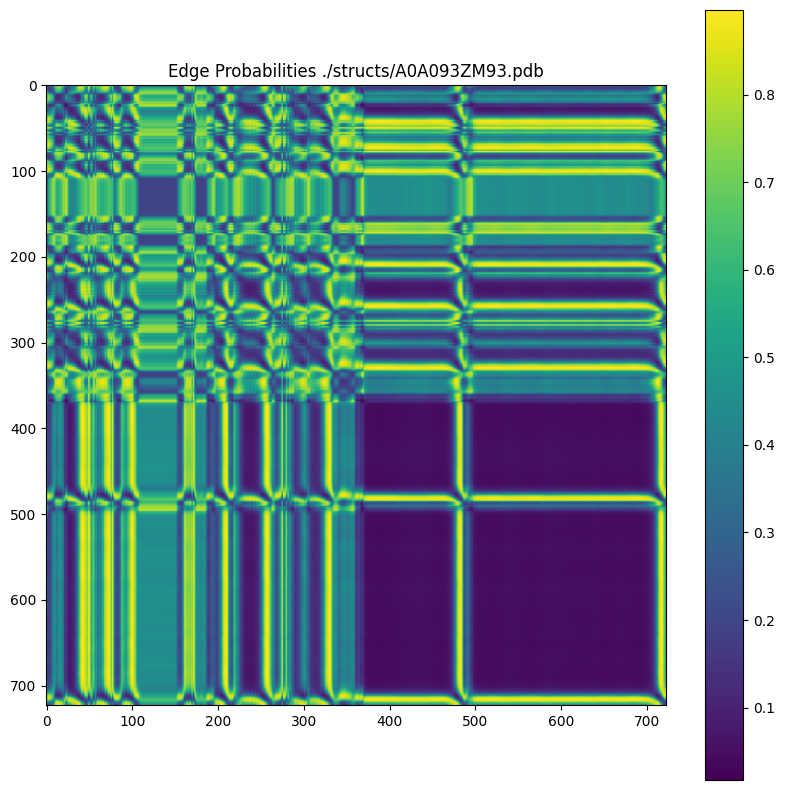

./structs/A0A662CHN5.pdb
(4761,)
(69, 69)
[[0.78097177 0.7948653  0.80020565 ... 0.73238176 0.6557106  0.60526574]
 [0.7948653  0.81489205 0.8251589  ... 0.7259814  0.62168103 0.55542743]
 [0.80020565 0.8251589  0.8417175  ... 0.72943676 0.5974499  0.5136528 ]
 ...
 [0.73238176 0.7259814  0.72943676 ... 0.7975109  0.76696664 0.7378213 ]
 [0.6557106  0.62168103 0.5974499  ... 0.76696664 0.79835695 0.8049836 ]
 [0.60526574 0.55542743 0.5136528  ... 0.7378213  0.8049836  0.8289453 ]]


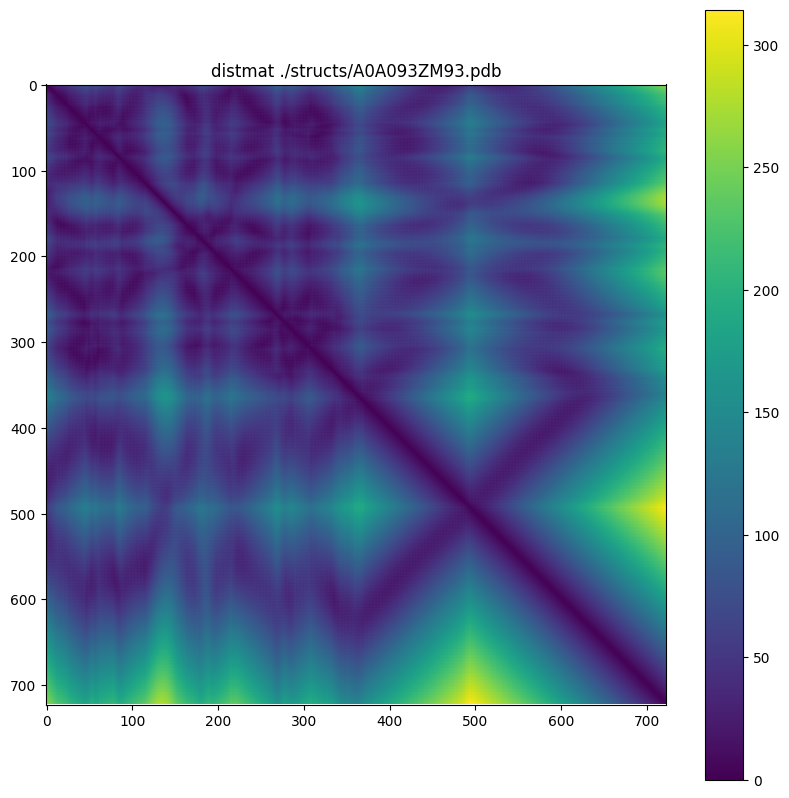

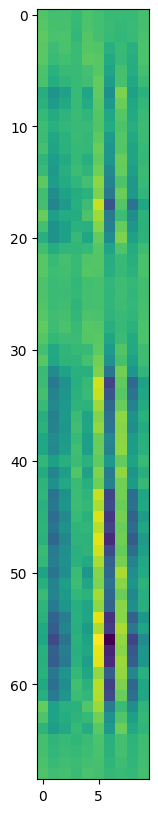

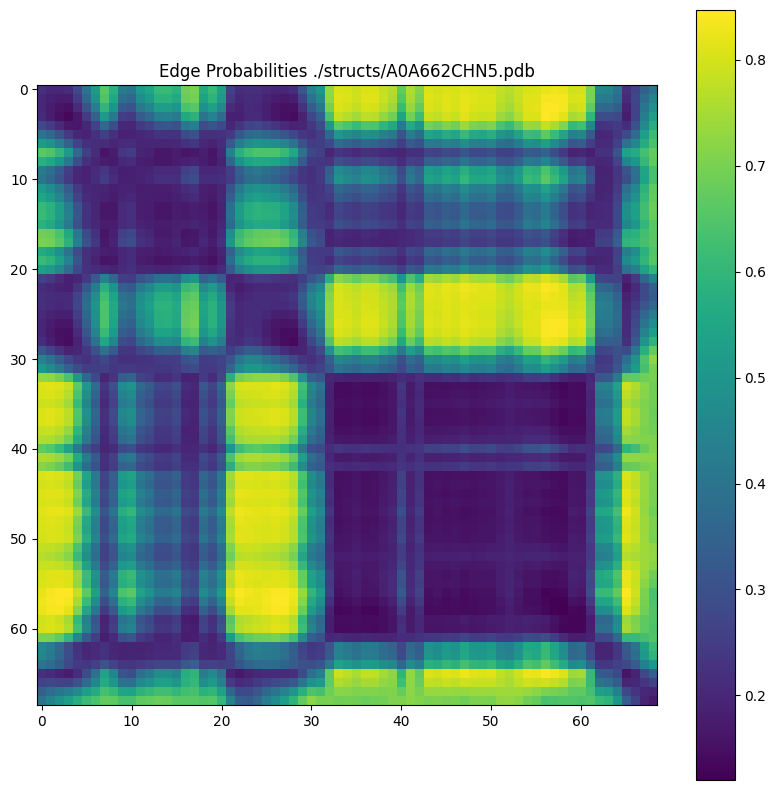

./structs/A0A1Z4SDS6.pdb
(15876,)
(126, 126)
[[0.9423751  0.93670183 0.9259643  ... 0.20034397 0.42770582 0.5206439 ]
 [0.93670183 0.9322989  0.9228294  ... 0.19015501 0.38682982 0.47548094]
 [0.9259643  0.9228294  0.9146686  ... 0.18609092 0.34972242 0.4288523 ]
 ...
 [0.20034397 0.19015501 0.18609092 ... 0.77926105 0.7401411  0.7054805 ]
 [0.42770582 0.38682982 0.34972242 ... 0.7401411  0.84110045 0.84465283]
 [0.5206439  0.47548094 0.4288523  ... 0.7054805  0.84465283 0.8579421 ]]


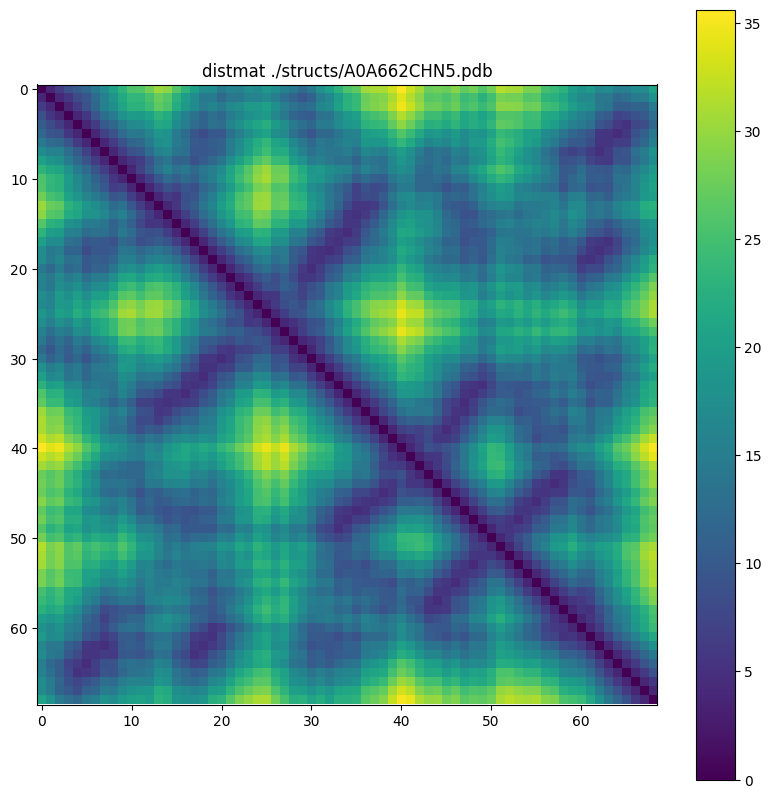

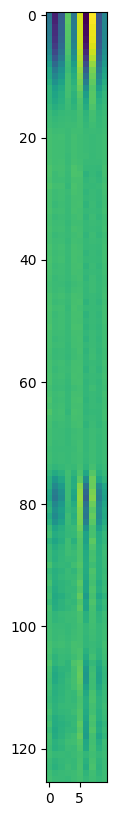

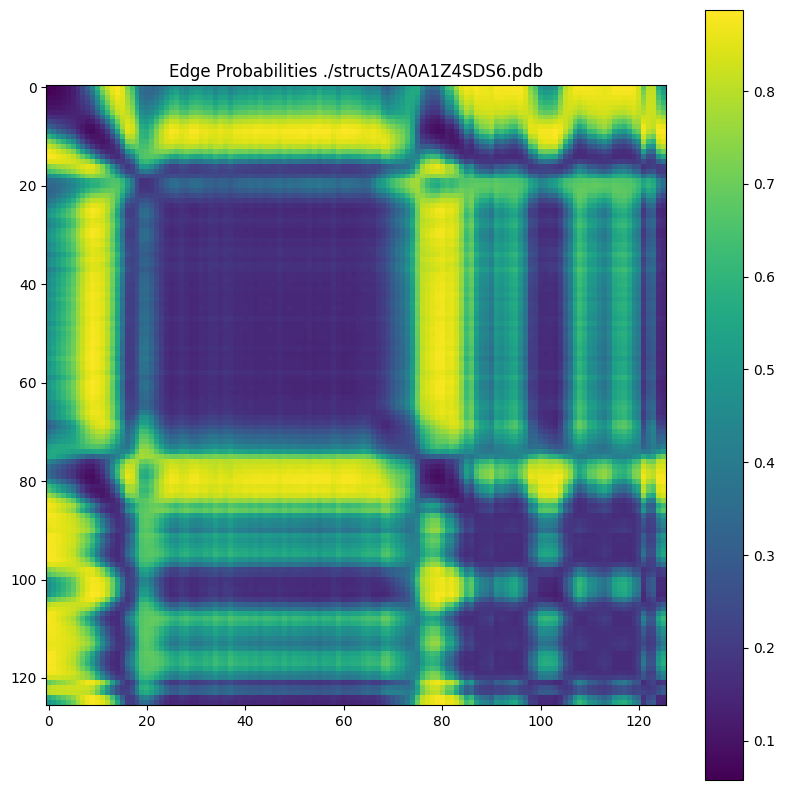

./structs/A0A5B7XUB5.pdb
(23409,)
(153, 153)
[[0.95942336 0.9594335  0.9590751  ... 0.58199364 0.61689675 0.6047767 ]
 [0.9594335  0.95945585 0.9591133  ... 0.5837276  0.6183621  0.60639656]
 [0.9590751  0.9591133  0.958789   ... 0.5863312  0.6205213  0.6087908 ]
 ...
 [0.58199364 0.5837276  0.5863312  ... 0.8468134  0.8514164  0.8517327 ]
 [0.61689675 0.6183621  0.6205213  ... 0.8514164  0.8573363  0.8570767 ]
 [0.6047767  0.60639656 0.6087908  ... 0.8517327  0.8570767  0.85707074]]


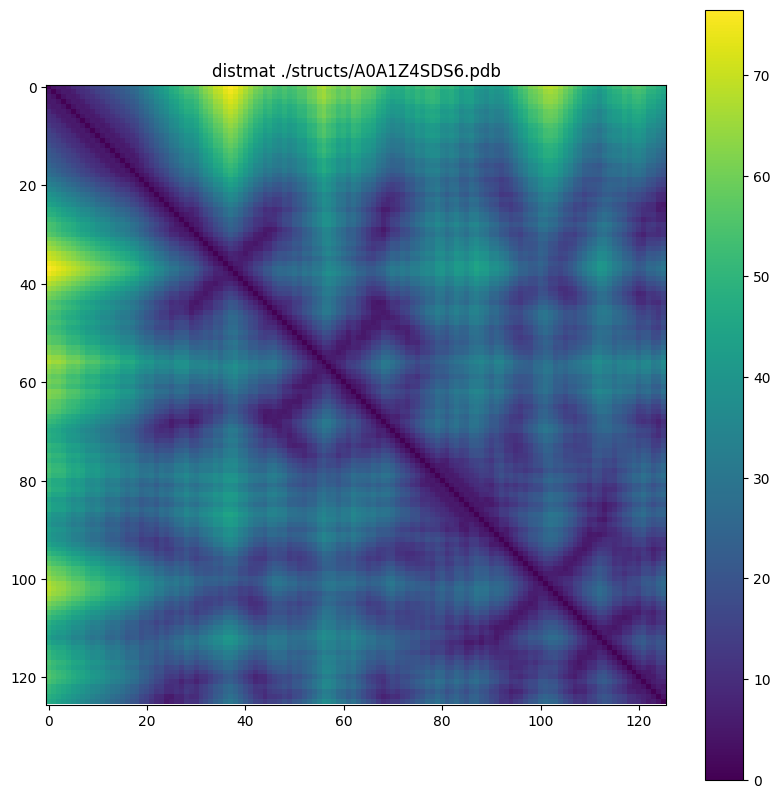

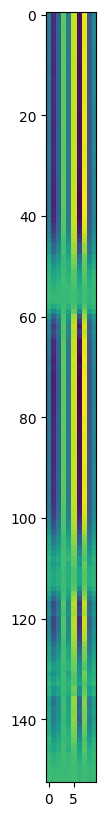

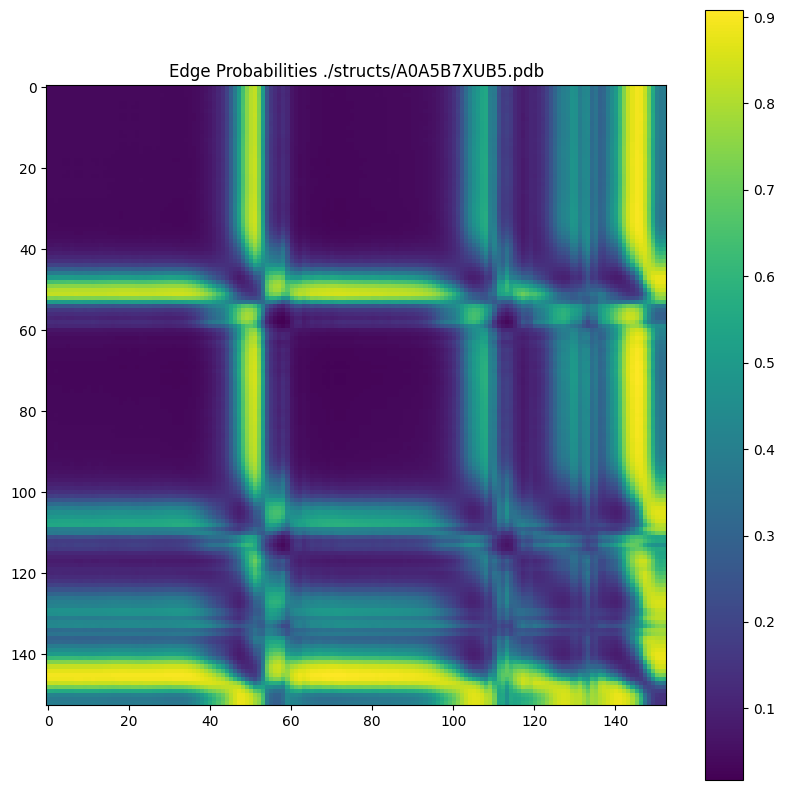

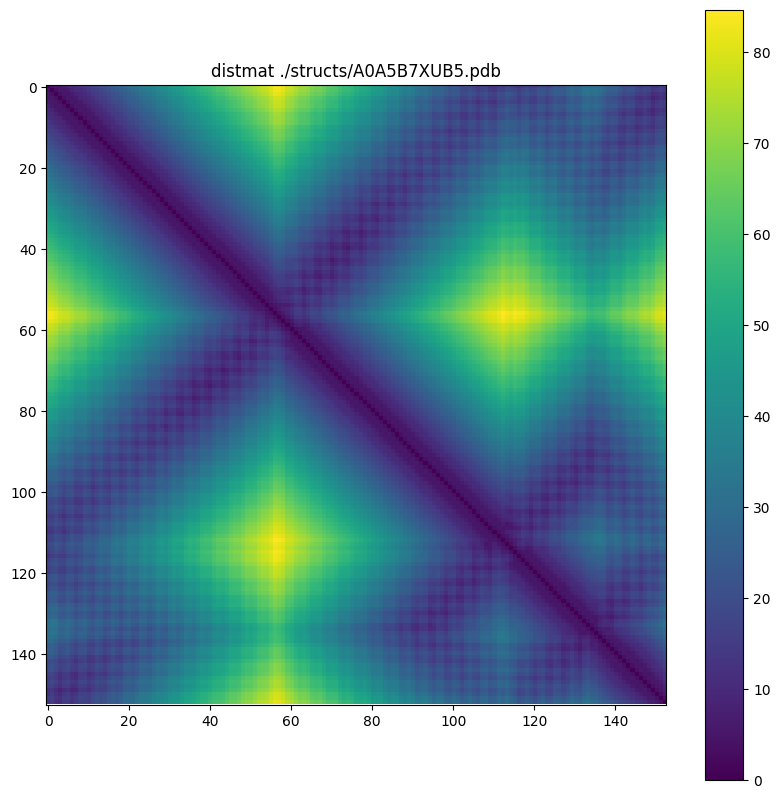

In [66]:
from matplotlib import pyplot as plt

def plot_embeddings(filename, encoder, decoder):
    z, recon_x, edge_probs = predict_structure(filename, encoder, decoder)
    z = z.detach().cpu().numpy()
    edge_probs = edge_probs.detach().cpu().numpy()
    print(edge_probs.shape)
    #reshape the edge probabilities into a matrix
    edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
    print(edge_probs.shape)
    print(edge_probs)
    #get edge index for the structure
    #control the aspect ratio
    plt.figure(figsize=(10,10))
    plt.imshow(z)
    plt.show()

    #plot the edge probabilities
    plt.figure(figsize=(10,10))
    plt.title('Edge Probabilities ' + filename)
    plt.imshow(1-edge_probs)
    plt.colorbar()
    plt.show()

    #plot the distance matrix
    chain = read_pdb(filename)[0]
    chain = [ r for r in chain if PDB.is_aa(r)]
    distances = np.zeros((len(chain), len(chain)))
    for i in range(len(chain)):
        for j in range(len(chain)):
            distances[i,j] = chain[i]['CA'] - chain[j]['CA']
    plt.figure(figsize=(10,10))
    plt.title('distmat ' + filename)

    plt.imshow(distances)
    plt.colorbar()


#plot a few embeddings from example structures

for structure in structures[0:10]:
    print(structure)
    plot_embeddings(structure, encoder, decoder)


In [ ]:
#make a an examples folder and copy the example structures there
import shutil

if not os.path.exists('./examples'):
    os.makedirs('./examples')

for structure in structures[0:10]:
    shutil.copy(structure, './examples/' + structure.split('/')[-1] )



In [52]:
#fit kmeans to the embeddings
import logomaker

# load crp energy matrix
crp_df = -logomaker.get_example_matrix('crp_energy_matrix',
                                        print_description=False)
print(  crp_df.head() )

            A         C         G         T
pos                                        
0    0.183642 -0.155864 -0.094136  0.066358
1    0.290123 -0.277778 -0.111111  0.098765
2    0.276235 -0.316358 -0.168210  0.208333
3    0.226852 -0.285494 -0.297840  0.356481
4    0.060185 -0.143519 -0.057099  0.140432


In [ ]:
#try running the cluster centers through the decoder
#predict the embeddings for a structure
import os
from sklearn.cluster import KMeans
import pickle
import logomaker

kmeans_dir = './kmeans/'

for nclusters in [ 20, 50 , 80,  100, 200, 256]:
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(zvals)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    #save each of the kmeans 
    if not os.path.exists(kmeans_dir):
        os.makedirs(kmeans_dir)
    with open(kmeans_dir + str(nclusters)+'_kmeans.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

    #get the covariance within clusters
    cov = np.zeros((nclusters, zvals.shape[1], zvals.shape[1]))
    for i in range(nclusters):
        cov[i] = np.cov(zvals[labels == i].T)
    print(cov.shape)

    #get the means within clusters
    means = np.zeros((nclusters, zvals.shape[1]))
    for i in range(nclusters):
        means[i] = np.mean(zvals[labels == i], axis=0)
    print(means.shape)

    #save the mean and covariance for clusters in .npy
    np.save(kmeans_dir + str(nclusters)+'_means.npy', means)
    np.save(kmeans_dir + str(nclusters)+'_cov.npy', cov)


In [ ]:

def draw_sample( mean , covar):
    #draw samples from the mean and covariance
    #operating under the assumption that its a multivariate gaussian
    return np.random.multivariate_normal(mean, covar)

def draw_nsamples( mean, covar , n):
    samples = [draw_sample(mean, covar) for i in range(n)]
    return np.vstack(samples)

#draw samples from the cluster centers for a given sequence of labels
def labels_cluster_samples( labels , mean , covar ):
    embed_sample = [ draw_sample(mean[labels[i]], covar[labels[i]]) for l in range(len(labels))]
    return embed_sample

def draw_n_label_samples(labels, mean, covar , n = 10):
    samplings = [ labels_cluster_samples( labels , mean , covar ) for i in range(n) ]
    return samplings

def decode_samples(samplings , decoder , retstack = False):
    #create all vs all edge index
    edge_index = torch.tensor( [ [i,j] for i in range(s.shape[0]) for j in range(s.shape[0]) ] ).T
    #create a backbone edge index
    backbone = torch.tensor( [i,j] for i in range( s.shape[0] ) for j in range(s.shape[0]) )
    backbone = backbone.to(device)
    print(edge_index)
    edge_index = edge_index.to(device)
    x_stack = []
    edge_stack= []
    for samples in samplings:
        s = torch.tensor(s)
        s = s.to(device)
        recon_x, edge_probs = decoder(s, edge_index , backbone ] )
        x_stack.append( recon_x)
        edge_stack.append( edge_probs)
    
    #get the mean and variance elementwise
    if retstack == True:
        return edge_stack , x_stack

    if retstack == False:
        x_stack = np.dstack(x_stack)
        edge_stack = np.dstack( edge_probs ) 

        edge_means = np.mean( edge_stack , axis = 2)
        edge_vars = np.var(edge_stack , axis = 2)

        x_means = np.mean(edge_stack , axis = 2)
        x_vars = np.var(edge_stack , axis = 2)

        return edge_means, edge_vars , x_means, x_vars


def decoded_to_seq(x_means , decode_dict):
    #transform a on hot matrix of AA probabilities to a sequence
    #get max index of each row
    indices = np.argmax( x_means , axis = 1 )
    seq = [ decode_dict[c] for c in list(indices)]
    return seq


def plot_edgestack(edge_means, edge_vars):
    #plot a scatterplot with the dot size representing the inverse of the variance 
    # and the color representing the contact proba
    
    #xy grid for scatterplot
    xv, yv = np.meshgrid(x = np.arrange( edge_means.shap[0]) , y = np.arrange(edge_means.shap[1]) = , indexing='ij')

    #colors with the means
    colors = edge_means.flatten()

    #dot size with the vars
    sizes = 1/edge_vars.flatten()
    plt.scatter( xv , yv , s = sizes , c = colors , cmap = 'viridis')
    plt.show()


def plot_logo(x_means, decode_dict):
    #plot an hmm type logo with the sequence reconstruction  
    seqdf = pd.DataFrame(x_means, columns = decode_dict.keys())
    #plot the logo
    logo = logomaker.Logo(seqdf, color_scheme='chemistry')
    return logo




In [ ]:


#predict the embeddings for a structure
def predict_structure_discrete(structure, encoder, decoder , kmeans = kmeans):
    data = struct2pyg(structure, aaproperties)
    data = data.to(device)
    z = encoder.forward(data['res'].x, data.edge_index_dict)
    #classif each node to a cluster
    labels = kmeans.predict(z.detach().cpu().numpy())
    #get the corresponding cluster centers
    zcenters = torch.tensor(centers[labels])
    #create all vs all edge index
    edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T
    print(edge_index)
    recon_x, edge_probs = decoder(zcenters, edge_index , data.edge_index_dict[( 'res','backbone','res')] )
    return z, recon_x, edge_probs

for nclusters in [ 20, 50 , 80,  100, 200, 256]:
    with open(kmeans_dir + str(nclusters)+'_kmeans.pkl', 'rb') as f:
        kmeans = pickle.load(f)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        print(centers.shape)
        #predict with the 1st example
        z, recon_x, edge_probs = predict_structure_discrete( filename , encoder, decoder , kmeans)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


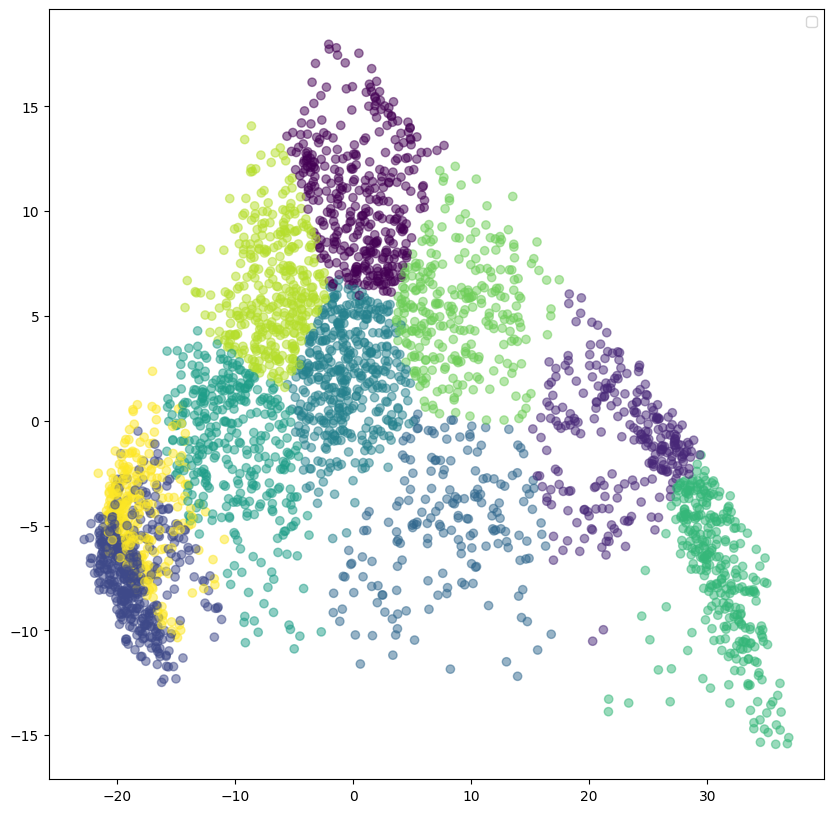

In [ ]:
#pca zvals to 2d
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
zvals = pca.fit_transform(zvals)
#use kmeans to color the embeddings
plt.figure(figsize=(10,10))
plt.scatter(zvals[:,0], zvals[:,1], c=kmeans.labels_ , alpha=0.5 )
plt.legend()
plt.show()


In [ ]:
#make an embedding vector for all structures and save it in an h5 file
charsets = [10,20,40,80,128,256,512]

def make_embedding(structures, encoder, decoder, kmeans, filename = 'embeddings.h5'):
    with h5py.File(filename, 'w') as f:
        for structure in tqdm.tqdm(structures):
            z, recon_x, edge_probs = predict_structure_discrete(structure, encoder, decoder , kmeans)
            #
            uniID = filename.split('/')[-1].split('.')[0]
            #store the embeddings under the label of embedding
            f.create_group(uniID)
            f[uniID].create_dataset('z', data=z)
    return filename


#

#make_embedding(structures, encoder, decoder, kmeans, filename = 'embeddings.h5')

In [ ]:
print( len( zvals_stack) , len(edge_probs_stack) )

print( zvals_stack[0].shape , edge_probs_stack[0].shape)

#resahpe all the edge probabilities

edge_probs_stack = [ e.reshape((zvals_stack[i].shape[0], zvals_stack[i].shape[0] )) for i,e in enumerate(edge_probs_stack)] 
print( edge_probs_stack[0].shape)



10 10
(281, 10) (78961,)
(281, 281)


In [ ]:
#select n first residues from each structure

n = 50
zvals_stack = [ z[0:n] for z in zvals_stack]
edge_probs_stack = [ e[0:n, 0:n] for e in edge_probs_stack]

#unroll the edge probabilities into a vector

edge_probs_stack = [ e.flatten() for e in edge_probs_stack]


In [ ]:
#use matmul to get the dot product of the embeddings

dotprods = [ np.matmul(z.T, z) for z in zvals_stack]
#unroll the dot products into a vector
dotprods = [ d.flatten() for d in dotprods]


In [ ]:

#concatenate the edge probabilities with the embeddings
zvals_stack = np.vstack(zvals_stack)
print( zvals_stack.shape)
edge_probs_stack = np.vstack(edge_probs_stack)
print( edge_probs_stack.shape)




(500, 10)
(10, 2500)


In [ ]:
#remove all .bkup and .csv files
import os
import glob
files = glob.glob('./*.bkup')
files += glob.glob('./*.csv.out*')
for f in files:
    os.remove(f)


In [ ]:
"""
#use symbolic regression to find the relationship between the embeddings and the edge probabilities
#propose a folding mechanism
from pysr import pysr, best

#use symbolic regression to find the relationship between the embeddings and the edge probabilities
#use matrix multiplication and addition as the binary operators
#use the embeddings as the input variables

#minimum logfiles 
import logging
logging.basicConfig(level=logging.ERROR)


equations = pysr(dotprods, edge_probs_stack, niterations=10, binary_operators=['+', '*' ,'^' , '/' , '-' ], 
                unary_operators=[ 'log10' , 'sin' , 'relu' , 'cos' , 'abs' ]  , procs=20 , verbosity=0 , nrestarts=10)

print(best(equations))

#use the symbolic regression equation to predict the edge probabilities
import sympy
from sympy import symbols, Function
from sympy.parsing.sympy_parser import parse_expr

x, y = symbols('x y')
f = parse_expr(best(equations))
f = sympy.lambdify(x, f, 'numpy')
xvals = np.linspace(-10,10,100)
yvals = f(xvals)
plt.plot(xvals, yvals)
plt.show()

#plot the edge probabilities
plt.figure(figsize=(10,10))
plt.imshow(1-edge_probs)
plt.colorbar()
plt.show()

"""

In [ ]:
"""#use the symbolic regression equation to predict the edge probabilities

edge_probs_pred = f(zvals)
print(edge_probs_pred.shape)
#plot the edge probabilities
plt.figure(figsize=(10,10))
plt.imshow(1-edge_probs_pred)
"""


In [ ]:
in_channels=ndim
hidden_channels=50
out_channels = 25
nlayers=2

encoder = HeteroVGAE_Encoder(in_channels=in_channels,  out_channels=out_channels, metadata=metadata)
decoder = HeteroGraphDecoder(hidden_channels=100 , encoder_out_channels = out_channels , metadata=metadata)

In [ ]:
import torch
import pytorch_lightning as pl
from torch_geometric.nn import models
import torch.nn.functional as F
from torch_geometric.utils import (negative_sampling, remove_self_loops, add_self_loops)

class GraphAutoencoder(pl.LightningModule):
    def __init__(self, model_name, in_channels, out_channels, hidden_channels, nlayers, learning_rate, encoder_cls, decoder_cls, metadata):
        super(GraphAutoencoder, self).__init__()
        self.save_hyperparameters()
        self.encoder = HeteroVGAE_Encoder(in_channels=in_channels,hidden_channels=hidden_channels,  out_channels=out_channels, metadata=metadata, nlayers=nlayers)
        self.decoder = HeteroGraphDecoder(hidden_channels, out_channels, metadata['edge_types']) if decoder_cls else None
        self.model = models.VGAE(self.encoder) if self.decoder is None else models.VGAE(self.encoder , self.decoder) 
        self.learning_rate = learning_rate
        self.name = model_name

    def forward(self, x_dict, edge_index_dict):
        return self.model.encode(x_dict, edge_index_dict), self.model.decode(self.model.__mu__, self.model.__logvar__)

    def training_step(self, batch, batch_idx):
        x_dict, edge_index_dict = batch.x_dict, batch.edge_index_dict
        z, edge_recon = self.forward(x_dict, edge_index_dict)
        # Reconstruction loss
        loss = self.reconstruction_loss(edge_index_dict, edge_recon)
        # KL divergence loss
        kl_loss = 0.5 / z.size(0) * torch.mean(torch.sum(1 + 2 * self.model.__logvar__ - self.model.__mu__**2 - self.model.__logvar__.exp()**2, dim=1))
        
        total_loss = loss - kl_loss
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return total_loss

    def reconstruction_loss(self, edge_index_dict, edge_recon):
        # Implement the specific reconstruction loss for your graph data
        loss = 0
        for edge_type, edge_index in edge_index_dict.items():
            src, dst = edge_type.split('_')[:2]
            pos_loss = -torch.log(edge_recon[edge_type] + 1e-15).mean()
            neg_edge_index = negative_sampling(edge_index, edge_recon[edge_type].size(0))
            neg_loss = -torch.log(1 - edge_recon[edge_type][neg_edge_index[0], neg_edge_index[1]] + 1e-15).mean()
            loss += pos_loss + neg_loss
        return loss



    def validation_step(self, batch, batch_idx):
        # Similar to training_step, calculate the loss for validation data
        pass

    def test_step(self, batch, batch_idx):
        # Similar to training_step, calculate the loss for test data
        pass

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
def train_autoencoder(model_name, dataloader, in_channels=ndim , hidden_channels=50, out_channels = 10, nlayers=2, learning_rate=0.001, encoder=encoder, decoder=decoder , metadata=metadata ,**model_kwargs):
    node_data_loader = dataloader
    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=True,
    )  # 0 because epoch size is 1
    
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphAutoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = GraphAutoencoder(model_name=model_name, in_channels=in_channels, hidden_channels=hidden_channels, out_channels = out_channels , nlayers=nlayers, learning_rate=learning_rate , encoder_cls=encoder, decoder_cls=decoder , metadata=metadata )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = GraphAutoencoder.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result
    

In [ ]:
#creat a dataloader
from torch_geometric.data import DataLoader
def create_dataloader(dataset, batch_size=5, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
dataloader = create_dataloader(struct_dat)

In [ ]:
#train the model on the dataset
"""
model, result = train_autoencoder( 'autoencoder', dataloader, in_channels=ndim , hidden_channels=100, out_channels = 10 ,  nlayers=2, learning_rate=0.001, encoder=encoder, decoder=decoder , metadata = metadata )

#save the model
torch.save(model.state_dict(), 'autoencoder.pth')

#load the model
model.load_state_dict(torch.load('autoencoder.pth'))

#evaluate the model
model.eval()
with torch.no_grad():
    for data in dataloader:
        data = data.to(model.device)
        z = model.encode(data.x, data.edge_index)
        #get the reconstruction
        recon = model.decode(z, data.edge_index)
        #get the loss
        loss = F.mse_loss(recon, data.x)
        print(loss)


"""

In [ ]:
def reconstruction_loss( edge_index_dict, edge_recon):
        # Implement the specific reconstruction loss for your graph data
        loss = 0
        for edge_type, edge_index in edge_index_dict.items():
            src, dst = edge_type[:2]
            pos_loss = -torch.log(edge_recon[edge_type] + 1e-15).mean()
            neg_edge_index = negative_sampling(edge_index, edge_recon[edge_type].size(0))
            neg_loss = -torch.log(1 - edge_recon[edge_type][neg_edge_index[0], neg_edge_index[1]] + 1e-15).mean()
            loss += pos_loss + neg_loss
        return loss



In [ ]:
#training loop without pytorch lightning
#for global graph
import torch
import torch.nn.functional as F
from torch_geometric.nn import VGAE
from torch.optim import Adam
from torch_geometric.data import DataLoader

#init device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device( 'cpu')
print(device)

# Create a VGAE model
model = VGAE(encoder, decoder)

model = model.to(device)
# Create a DataLoader for training
train_loader = DataLoader(struct_dat, batch_size=10, shuffle=True)
from torch_geometric.loader import NeighborLoader


# Create an optimizer
optimizer = Adam(model.parameters(), lr=0.01)
# Training loop
model.train()
for epoch in range(200):
    total_loss = 0
    for data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{200}", leave=False):
        optimizer.zero_grad()
        data = data.to(device)
        #forward pass
        z = model.encode(data['res'].x, data.edge_index_dict)
        recon = model.decode(z)
        loss =reconstruction_loss( data.edge_index_dict , recon)
        loss.backward()
        total_loss += loss.item()  # Accumulate loss
        optimizer.step()
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{200}, Loss: {total_loss/len(train_loader)}")
    total_loss = 0

#save the model
torch.save(model.state_dict(), 'autoencoder.pth')


In [ ]:
#training loop without pytorch lightning
#for local graph
import torch
import torch.nn.functional as F
from torch_geometric.nn import VGAE
from torch.optim import Adam
from torch_geometric.data import DataLoader

#init device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device( 'cpu')
print(device)

# Create a VGAE model
model = VGAE(encoder, decoder)

model = model.to(device)
# Create a DataLoader for training
train_loader = DataLoader(struct_dat, batch_size=32, shuffle=True)



from torch_geometric.loader import NeighborLoader


# Create an optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
model.train()

for epoch in range(200):
    total_loss = 0
    for data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{200}", leave=False):


        local_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node for 2 iterations
        num_neighbors=[5] * 2,
        # Use a batch size of 128 for sampling training nodes
        batch_size=12,
        input_nodes= list(data.edge_index_dict[('res' , 'contactPoints','res')][0]),
        )   

        for local_data in local_loader:
            optimizer.zero_grad()
            data = data.to(device)
            #forward pass
            z = model.encode(data['res'].x, data.edge_index_dict)
            recon = model.decode(z)
            loss =reconstruction_loss( data.edge_index_dict , recon)
            loss.backward()
            total_loss += loss.item()  # Accumulate loss
            optimizer.step()
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{200}, Loss: {total_loss/len(train_loader)}")
    total_loss = 0

In [ ]:
# Evaluate the model
model.eval()
for data in test_loader:
    data = data.to(model.device)
    z = model.encode(data.x, data.edge_index)
    recon = model.decode(z, data.edge_index)
    loss = F.mse_loss(recon, data.x)
    print(loss)

In [ ]:
model = torch.jit.script(model)
#save the model
model.save('autoencoder.pt')

#save only the encoder
encoder = model.encoder
encoder = torch.jit.script(encoder)
encoder.save('encoder.pt')

#save only the decoder
decoder = model.decoder
decoder = torch.jit.script(decoder)
decoder.save('decoder.pt')



In [ ]:


#load the encoder

encoder = torch.jit.load('encoder.pt')
encoder.eval()

#pass the training data through the encoder
embeddings = []


with torch.no_grad():
    for data in dataloader:
        data = data.to(model.device)
        #get the embeddings in numpy
        z = encoder(data.x, data.edge_index).detach().numpy()
        embeddings.append(z)
embeddings = np.vstack(embeddings)
print(embeddings.shape)

In [ ]:
#use a kmeans clustering algorithm to cluster the embeddings
#this will define our alphabet

from sklearn.cluster import KMeans
def cluster_embeddings(embeddings, nclusters = 256):
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(embeddings)
    return kmeans

#use the kmeans model to predict the clusters for a set of embeddings
def predict_clusters(kmeans, embeddings):
    return kmeans.predict(embeddings)

def clusternum2ascii(cluster):
    return chr(cluster + 65)

def struct2ascii(embeddings, kmeans):
    clusters = list(predict_clusters(kmeans, embeddings))
    asciistr = ''.join([ clusternum2ascii(cluster) for cluster in clusters ])
    return asciistr


In [ ]:
#train the kmans model
kmeans = cluster_embeddings(embeddings, nclusters = 256)
#save the kmeans model
import pickle
with open('kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)




In [ ]:

def structs2ascii(outfile , structures, kmeans, model, aaproperties , threads = 1 , output_contacts = False):
    #turn structures into a fasta with ascii strings
    embeddings = encode_structures(model, structures, aaproperties, threads = threads,  verbose = False)
    if output_contacts == True:
        contactpts = structs2contactpts(structures, radius = 8 , threads = threads )
    with open(outfile, 'w') as f:
        for i,structure in enumerate(structures):
            contacts = contactpts[i]
            asciistr = struct2ascii(embeddings[i], kmeans)
            f.write('>' + structure + '\n')
            #comma separated contact points
            if output_contacts == True:
                f.write('#x:' + ','.join( contacts[0] ) + '\n' )
                f.write('#y:' + ','.join( contacts[1] ) + '\n' )
            #ascii string of structural embeddings            
            f.write(asciistr + '\n')
    return outfile


In [ ]:
#download some examples from each cluster

#use explicit aln to comput submats

#use explicit aln to compute the compatibility matrix



In [ ]:
#train a decoder from a graph with prot alphabet to amino acid letters
#the contact mat is available for stuff from the aln 





In [ ]:
#text aligner with mafft


In [ ]:
#output links into potts model with graph 

#calculate ancestral sequences

#calculate the state transition energies

#calculate the state transition probabilities

import phylotreelib as pt
tree1 = pt.Tree.randtree(ntips=50, randomlen=True)
tree2 = tree1.copy_treeobject()
for i in range(5):
    tree2.spr()
